In [1]:
"""
Necessary modules
"""
import sys, os
%load_ext autoreload
%autoreload 2 # autoreload to debug/modify modules
import numpy as np
from graphs.my_graph import * # my custom module for plots
%matplotlib inline

# Extra- and Intracellular recordings in awake mice

In [2]:
%run cortical_arousal_index/exp_data.py
# to get "args"
args.subsampling_period = 1e-3
data = load_data('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf',
                 args,
                 chosen_window_only=True, full_processing=True)

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
f0, w0, T0 = get_pLFP_parameters_from_scan(datafile1='cortical_arousal_index/data/final_wvl_scan.npz',
                                           datafile2='cortical_arousal_index/data/final_smooth.npz')
functions.preprocess_LFP(data,
                         freqs=np.linspace(f0/w0, f0*w0, args.wavelet_number),
                         new_dt=args.subsampling_period,
                         smoothing=0) # HERE NO SMOOTHING YET !!
data['pLFP0'] = data['pLFP'] # storing the pLFP value
functions.preprocess_LFP(data,
                         freqs=np.linspace(f0/w0, f0*w0, args.wavelet_number),
                         new_dt=args.subsampling_period,
                         smoothing=T0) # HERE NO SMOOTHING YET !!

wavelet pack in band: [ 39.7 , 133.6 ]Hz
with smoothing time constant  42.2 ms


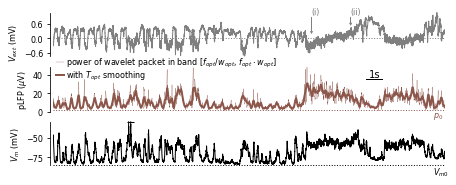

In [4]:
t0, width = 83.5, 25
spikes=-30
vm_color=Grey
LFP_color='k'
T_bar=1.
subsampling = 1 # put to 1 for final figure !!

fig_raw, [[ax1], [ax2], [ax3]] = figure(figsize=(.75,.2),
                                        left=.3, bottom=.1,
                                        axes=(3,1), hspace=.3)
# time bar
ax2.plot(t0+width-5+np.arange(2), np.ones(2)*35, 'k-', lw=1)
ax2.annotate('1s', (t0+width-5+.15, 37))
tn1, tn2 = t0+width-8.5, t0+width-6. 
ax1.arrow(tn1, 0.9, 0., -.6, head_width=0.15, head_length=0.1, fc=Grey, ec=Grey, lw=0.5)
ax1.arrow(tn2, 0.9, 0., -.25, head_width=0.15, head_length=0.1, fc=Grey, ec=Grey, lw=0.5)
ax1.annotate('(i)', (tn1, 1.), fontsize=FONTSIZE, color=Grey)
ax1.annotate('(ii)', (tn2, 1.), fontsize=FONTSIZE, color=Grey)

cond = (data['sbsmpl_t']>t0) & (data['sbsmpl_t']<t0+width)
ax1.plot(data['sbsmpl_t'][cond][::subsampling], data['sbsmpl_Extra'][cond][::subsampling], '-', lw=1, color=Grey)
ax1.plot([t0, t0+width], np.zeros(2), ':', lw=1, color=Grey)
ax2.plot(data['sbsmpl_t'][cond][::subsampling], data['pLFP0'][cond][::subsampling],
         '-', color=Brown, lw=0.3,
         label='power of wavelet packet in band [$f_{opt}$/$w_{opt}$, $f_{opt} \cdot w_{opt}$]')
ax2.plot(data['sbsmpl_t'][cond][::subsampling], data['pLFP'][cond][::subsampling], '-', color=Brown,
         lw=2, label='with $T_{opt}$ smoothing')
ax2.legend(loc=(0,.57), frameon=False, fontsize=FONTSIZE, labelspacing=-0.05, handlelength=1, handletextpad=0.2)
ax2.plot([t0, t0+width], data['p0']*np.ones(2), ':', color=Brown, lw=1)
ax2.annotate('$p_{0}$', (.97, -0.07), color=Brown, xycoords='axes fraction', fontsize=FONTSIZE)
# Vm
ax3.plot(data['sbsmpl_t'][cond & (data['sbsmpl_Vm']<spikes)][::subsampling],
         data['sbsmpl_Vm'][cond & (data['sbsmpl_Vm']<spikes)][::subsampling], 'k-', lw=1)
ax3.plot([t0, t0+width], data['p0_Vm']*np.ones(2), ':', color='k', lw=1)
ax3.annotate('$V_{m0}$', (.97, -0.13), color='k', xycoords='axes fraction', fontsize=FONTSIZE)
ispk = np.argwhere((data['Vm'][:-1]<=spikes) & (data['Vm'][1:]>spikes) & (data['t'][1:]>t0)).flatten()
for i in ispk:
    ax3.plot(data['t'][i-10:i], np.concatenate([data['Vm'][i-10:i-1], [spikes]]), 'k-', lw=1)
    ax3.plot([data['t'][i]], [spikes], 'k_', ms=5)
set_plot(ax1, ['left'], xlim=[t0, t0+width], ylabel='$V_{ext}$ (mV)       ', yticks=[-.6,0,.6])
set_plot(ax2, ['left'], xlim=[t0, t0+width], ylabel='pLFP ($\mu$V)', num_yticks=3)
set_plot(ax3, ['left'], xlim=[t0, t0+width], ylabel='$V_{m}$ (mV)', num_yticks=3)

== OPTIMIZATION RESULTS == 
72.78953843983146 1.8348275862068966
39.67105083170668 133.55625311667006


/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


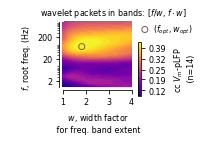

In [5]:
OUTPUT = dict(np.load('cortical_arousal_index/data/final_wvl_scan.npz'))

pCC = np.mean(OUTPUT['CROSS_CORRELS'], axis=-1)

i0, j0 = np.unravel_index(np.argmax(np.mean(OUTPUT['CROSS_CORRELS'], axis=-1), axis=None),
                          pCC.shape)
f0, w0 = OUTPUT['CENTER_FREQUENCIES'][i0], OUTPUT['BAND_LENGTH_FACTOR'][j0]

print('== OPTIMIZATION RESULTS == ')
print(f0, w0)
print(f0/w0, f0*w0)

fig_optimum, ax = figure(figsize=(.3, .16), right=.7, top=.9, bottom=1.2, left=.9)
p = plt.contourf(OUTPUT['BAND_LENGTH_FACTOR'],
                 OUTPUT['CENTER_FREQUENCIES'],
                 pCC,
                 levels=np.linspace(pCC.min(),pCC.max(),30),
                 cmap=plasma)
ax.scatter([w0], [f0], color=Brown, facecolor='None', label='($f_{opt}, w_{opt}$)')
ax.set_yscale('log')
ax.set_title('             wavelet packets in bands: [$f/w$, $f\cdot w$]', fontsize=FONTSIZE)
set_plot(ax, xlabel=' $w$, width factor\n for freq. band extent',
         ylabel=' $f$, root freq. (Hz)    ',
         yticks=[2, 20, 200], yticks_labels=['2', '20', '200'], xticks=np.arange(1, 5))
ax.legend(loc=(1.02, .73), handletextpad=0, frameon=False)
acb = plt.axes([.71,.32,.02,.4])
build_bar_legend(np.unique(np.round(np.linspace(pCC.min(),pCC.max(),6),2)),
                 acb, plasma,
                 color_discretization=30,
                 label='cc $V_m$-pLFP \n (n='+str(OUTPUT['CROSS_CORRELS'].shape[-1])+')')

In [6]:
# to run from the script
# args.datafile_input = 'cortical_arousal_index/data/final_smooth.npz'
# [fig_smooth] = plot_test_different_smoothing(args)
OUTPUT = dict(np.load('cortical_arousal_index/data/final_smooth.npz'))

mean_Output = np.mean(OUTPUT['CROSS_CORRELS'], axis=-1)
NORM = np.zeros(OUTPUT['CROSS_CORRELS'].shape)
Tsmooth = 1e3*OUTPUT['T_SMOOTH']
order = np.argsort(np.mean(OUTPUT['CROSS_CORRELS'], axis=0))
for i in range(len(order)):
    NORM[:,order[i]] = (OUTPUT['CROSS_CORRELS'][:,order[i]]-OUTPUT['CROSS_CORRELS'][0,order[i]])/\
        (OUTPUT['CROSS_CORRELS'][:,order[i]].max()-OUTPUT['CROSS_CORRELS'][0,order[i]])
i0 = np.argmax(np.mean(NORM, axis=-1))

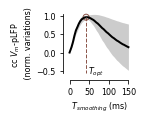

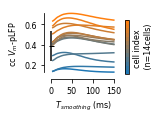

In [7]:
fig_optimum1, ax = figure(figsize=(.17, .16),top=0.9, bottom=1.2)
fig_optimum2, ax1 = figure(figsize=(.26, .16), top=0.9, bottom=1.2, right=.8)
    
colormap = get_linear_colormap(Blue, Orange)
                                 
for i in range(len(order)):
    ax1.plot(Tsmooth[1:], OUTPUT['CROSS_CORRELS'][1:,order[i]], color=colormap(i/(len(order)-1)))

ax1.errorbar([0], [OUTPUT['CROSS_CORRELS'][0,:].mean()],
             [OUTPUT['CROSS_CORRELS'][0,:].std()], fmt='k_', ms=5)
ax.plot(Tsmooth, np.mean(NORM, axis=-1), color='k', lw=2)
ax.fill_between(Tsmooth,\
                 np.mean(NORM, axis=-1)+np.std(NORM, axis=-1),
                 np.mean(NORM, axis=-1)-np.std(NORM, axis=-1),
                lw=0, color='k', alpha=.2)

i0 = np.argmax(np.mean(NORM, axis=-1))
ax.scatter([1e3*OUTPUT['T_SMOOTH'][i0]], [np.mean(NORM, axis=-1)[i0]],
           marker='o', color=Brown, facecolor='None')
ax.annotate('$T_{opt}$', (Tsmooth[i0]+4, ax.get_ylim()[0]), fontsize=FONTSIZE)
ax.plot(np.array([Tsmooth[i0], Tsmooth[i0]]),
        [np.mean(NORM, axis=-1)[i0], ax.get_ylim()[0]], '--', color=Brown, lw=1)
set_plot(ax, xlabel=' $T_{smoothing}$ (ms)',
         ylabel='cc $V_m$-pLFP \n (norm. variations)' )
set_plot(ax1, xlabel=' $T_{smoothing}$ (ms)',
         ylabel='cc $V_m$-pLFP')
acb = plt.axes([.82,.4,.03,.4])
cb = build_bar_legend(np.arange(len(order)),
                      acb, colormap,
                      no_ticks=True,
                      label='cell index \n (n='+str(len(order))+'cells)')


In [8]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig([fig_raw, fig_optimum, fig_optimum2, fig_optimum1],
                            fig_name='paper/Figures/Fig_pLFP_design.svg',
                            figsize=(0.593,0.261),
                            fontsize=FONTSIZE+1,
                            Props={'XCOORD':[15, -5, 180, 365],
                                   'YCOORD':[-5]+list(np.ones(3)*165),
                                   'XCOORD_LABELS':[-10, -10, 180, 330],
                                   'YCOORD_LABELS':[1]+list(np.ones(3)*160),
                                   'LABELS':['a','b', 'c', 'd']}, visualize=False)
export_as_png(os.getcwd()+'/paper/Figures/Fig_pLFP_design.svg', dpi=100)

In [42]:
from IPython.display import Image
#Image(filename='paper/Figures/Fig_pLFP_design.png', width=300)

# Diversity of Network States

In [10]:
%run cortical_arousal_index/exp_data.py
# args.Var_criteria = data['p0']
data = load_data('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf',
                 args,
                 chosen_window_only=True,
                 full_processing=True,
                 with_Vm_low_freq=True)

In [11]:
from cortical_arousal_index.plots import *

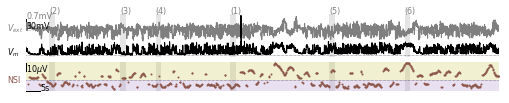

In [20]:
Zooms=[x-70+np.arange(2)*2 for x in [154.5, 90.2, 115.5, 128., 189.8, 216.6]]
fig_large, _ = show_raw_data_large_scale(data, Zooms, tstart=12, twidth=168);

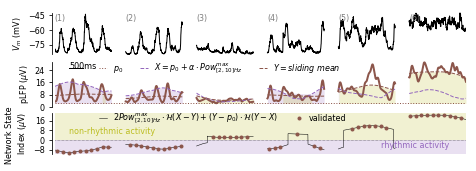

In [13]:
fig_zoom = show_raw_LFP_and_pLFP(data, Zooms, alpha=args.alpha, Tspace=0.5);

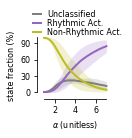

In [14]:
OUTPUT = dict(np.load('cortical_arousal_index/data/final_alpha.npz'))
fig_state, ax1 = figure(figsize=(.18, .15),top=0.9, bottom=1.2)
mean_synch, std_synch, mean_nc, std_nc,\
    mean_asynch, std_asynch, alpha = [], [], [], [], [], [], []
for i in range(OUTPUT['VM_LOW_FREQ_POWER'].shape[0]):
    mean_synch.append(np.mean(OUTPUT['N_LOW_FREQ'][i,:]/\
                              (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    std_synch.append(np.std(OUTPUT['N_LOW_FREQ'][i,:]/\
                            (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    mean_nc.append(np.mean(OUTPUT['N_NC'][i,:]/\
                              (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    std_nc.append(np.std(OUTPUT['N_NC'][i,:]/\
                            (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    mean_asynch.append(np.mean(OUTPUT['N_ASYNCH'][i,:]/\
                              (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    std_asynch.append(np.std(OUTPUT['N_ASYNCH'][i,:]/\
                            (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    # std.append(np.std(OUTPUT['VM_LOW_FREQ_POWER'][i,:][cond]))
    alpha.append(OUTPUT['ALPHA'][i])
for mean, std, color, label in zip([mean_nc, mean_synch, mean_asynch],\
                                   [std_nc, std_synch, std_asynch],\
                                   [Grey, Purple, Kaki],
                                   ['Unclassified', 'Rhythmic Act.', 'Non-Rhythmic Act.']):
    ax1.plot(alpha, 100.*np.array(mean), color=color, lw=2, label=label)
    ax1.fill_between(alpha, 100.*np.array(mean)+100.*np.array(std),
                     100.*np.array(mean)-100.*np.array(std), color=color, alpha=.2, lw=0)
set_plot(ax1, xlabel='$\\alpha$ (unitless)', ylabel='state fraction (%)')
ax1.legend(loc=(-0.15,0.9), prop={'size':FONTSIZE}, frameon=False, labelspacing=0, handlelength=1)

optimal alpha: 2.65


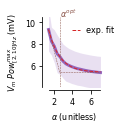

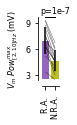

In [15]:
OUTPUT = dict(np.load('cortical_arousal_index/data/final_alpha.npz'))
fig_lf, ax2 = figure(figsize=(.15, .17),top=0.9, bottom=1.2)
mean, std, alpha = [], [], []
for i in range(OUTPUT['VM_LOW_FREQ_POWER'].shape[0])[3::2]:
    cond = np.isfinite(OUTPUT['VM_LOW_FREQ_POWER'][i,:]) & (OUTPUT['N_LOW_FREQ'][i,:]>10)
    mean.append(np.mean(OUTPUT['VM_LOW_FREQ_POWER'][i,:][cond]))
    std.append(np.std(OUTPUT['VM_LOW_FREQ_POWER'][i,:][cond]))
    alpha.append(OUTPUT['ALPHA'][i])
ylim = [4.1,10.5]
color=Purple    
ax2.plot(alpha, np.array(mean), color=color, lw=3)
ax2.fill_between(alpha, np.array(mean)+np.array(std),
                 np.array(mean)-np.array(std), color=color, alpha=.2, lw=0)
# exponential fit
def exp(x, p):
    return p[2]+p[1]*np.exp(-np.array(x)/p[0])
def to_minimize(p):
    return np.sum(np.abs(mean-exp(np.array(alpha)-alpha[0], p)))
from scipy.optimize import minimize
plsq = minimize(to_minimize, [2., 5., 5.])
ax2.plot(np.ones(2)*(alpha[0]+plsq.x[0]), ylim, '--', color=Brown, lw=.5)
ax2.annotate('$\\alpha^{opt}$', (alpha[0]+plsq.x[0], ylim[1]), color=Brown, fontsize=FONTSIZE)
ax2.plot((alpha[0], alpha[0]+plsq.x[0], alpha[-1]), [mean[0], plsq.x[2], plsq.x[2]], '--', color=Brown, lw=.5)
ax2.plot(alpha, exp(alpha-alpha[0], plsq.x), '--', color=Red, lw=1, label='exp. fit')
ax2.legend(loc=(.4,.7), frameon=False, prop={'size':FONTSIZE}, handlelength=1)
set_plot(ax2, xlabel='$\\alpha$ (unitless)', ylabel='$V_m$ $Pow_{[2,10]Hz}^{max}$ (mV)', ylim=ylim)
alpha0 = alpha[0]+plsq.x[0]
print('optimal alpha:', round(alpha0,2))


fig_pow, ax3 = figure(figsize=(.05, .17),top=0.9, bottom=1.2)

i0 = np.argmin(np.abs(OUTPUT['ALPHA']-alpha0))
bottom =2.5
for i in range(OUTPUT['VM_LOW_FREQ_POWER'].shape[1]):
    ax3.plot([0,1], [OUTPUT['VM_LOW_FREQ_POWER'][i0-1,i],OUTPUT['VM_LOW_FREQ_POWER_ASYNCH'][i0-1,i]], 'k-', lw=0.3)
ax3.bar([0], [np.mean(OUTPUT['VM_LOW_FREQ_POWER'][i0-1,:])-bottom], color=Purple,
        yerr=[np.std(OUTPUT['VM_LOW_FREQ_POWER'][i0-1,:])], bottom=bottom, lw=1)
ax3.bar([1], [np.mean(OUTPUT['VM_LOW_FREQ_POWER_ASYNCH'][i0-1,:])-bottom], color=Kaki,
        yerr=[np.std(OUTPUT['VM_LOW_FREQ_POWER_ASYNCH'][i0-1,:])], bottom=bottom, lw=1)
from scipy.stats import ttest_rel
ax3.plot([0,1], ax3.get_ylim()[1]*np.ones(2), 'k-', lw=1)
ax3.annotate('p='+\
             sci_str(ttest_rel(OUTPUT['VM_LOW_FREQ_POWER'][i0-1,:],\
                               OUTPUT['VM_LOW_FREQ_POWER_ASYNCH'][i0-1,:]).pvalue, rounding=0),
             (0,1.),xycoords='axes fraction', fontsize=FONTSIZE)
set_plot(ax3, yticks=[3,6,9], ylabel='$V_m$ $Pow_{[2,10]Hz}^{max}$ (mV)',
         xticks=[0,1], xticks_labels=['R.A. ','N.R.A.'], xticks_rotation=90)

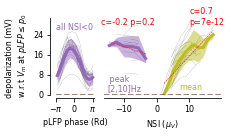

In [16]:
OUTPUT = dict(np.load('cortical_arousal_index/data/final_depol.npz'))
fig_comp_Vm, AX = figure(axes_extents=[[[1,1], [3,1]]], figsize=(0.45, 0.14), wspace=1e-9)
from scipy.stats import pearsonr

NEpisode_MIN = 3
with_single_cell_traces, lw = True, 0.1

# phase plot
Phase_Depol = [[] for k in range(len(OUTPUT['PHASE'][0]))]
Cell_Mean = []
for i in range(len(OUTPUT['FILENAMES'])):
    V0 = OUTPUT['VM_ASYNCH_LEVELS'][i][-1]
    cond = np.isfinite(OUTPUT['VM_PHASE_LEVELS'][i])
    Cell_Mean.append(np.mean(OUTPUT['VM_PHASE_LEVELS'][i][cond])-V0)
    for p, v in zip(OUTPUT['PHASE'][i][cond], OUTPUT['VM_PHASE_LEVELS'][i][cond]):
        i0 = np.argmin(np.abs(p-OUTPUT['PHASE'][0]))
        Phase_Depol[i0].append(v-V0)
    if with_single_cell_traces:
        AX[0][0].plot(OUTPUT['PHASE'][i][cond], OUTPUT['VM_PHASE_LEVELS'][i][cond]-V0, 'k-', lw=lw)
mean, std = [], []
for j in range(len(OUTPUT['PHASE'][0])):
    mean.append(np.mean(Phase_Depol[j]))                                  
    std.append(np.std(Phase_Depol[j]))                                  
AX[0][0].plot(OUTPUT['PHASE'][0], mean, lw=3, color=Purple)
AX[0][0].fill_between(OUTPUT['PHASE'][0], np.array(mean)+np.array(std),
                      np.array(mean)-np.array(std), color=Purple, alpha=.5, lw=0)

NSI_levels = np.linspace(1e-3, 18, 13)
Ncount, Depol = [np.zeros((len(NSI_levels), len(OUTPUT['FILENAMES']))) for k in range(2)]
NSI, mean, std = [], [], []
FULL_INPUT, FULL_OUTPUT = np.empty(0), np.empty(0)
for i in range(len(OUTPUT['FILENAMES'])):
    V0 = OUTPUT['VM_ASYNCH_LEVELS'][i][-1]
    binned = np.digitize(OUTPUT['NSI_ASYNCH_LEVELS'][i], bins=NSI_levels[:-1])
    for j in np.unique(binned):
        cond = (binned==j) & np.isfinite(OUTPUT['VM_ASYNCH_LEVELS'][i])
        Ncount[j,i] = len(OUTPUT['VM_ASYNCH_LEVELS'][i][cond])
        Depol[j,i] = np.mean(OUTPUT['VM_ASYNCH_LEVELS'][i][cond]-V0)
    if with_single_cell_traces:
        AX[0][1].plot(NSI_levels[Ncount[:,i]>NEpisode_MIN], Depol[:,i][Ncount[:,i]>NEpisode_MIN], 'k-', lw=lw)
for j in range(len(NSI_levels)-1):
    cond = Ncount[j,:]>NEpisode_MIN # minimum of episodes
    if len(Depol[j,:][cond])>1:
        NSI.append(.5*(NSI_levels[j]+NSI_levels[j+1]))
        mean.append(np.mean(Depol[j,:][cond]))
        std.append(np.std(Depol[j,:][cond]))
        FULL_INPUT = np.concatenate([FULL_INPUT, NSI_levels[j]*np.ones(len(Depol[j,:][cond]))])
        FULL_OUTPUT = np.concatenate([FULL_OUTPUT, Depol[j,:][cond]])
c, p = pearsonr(FULL_INPUT, FULL_OUTPUT)
AX[0][1].annotate('c='+str(round(c,1))+'\np='+sci_str(p), (10, 28), fontsize=FONTSIZE, color='r')
AX[0][1].plot(NSI, mean, lw=3, color=Kaki)
AX[0][1].plot(NSI, np.polyval(np.polyfit(NSI, mean, 1), NSI), 'r--', lw=0.5)
AX[0][1].fill_between(NSI, np.array(mean)+np.array(std), np.array(mean)-np.array(std),
                      color=Kaki, alpha=.5, lw=0)


NSI_levels = np.linspace(-1e-3, -20, 10)
Ncount, Depol = [np.zeros((len(NSI_levels), len(OUTPUT['FILENAMES']))) for k in range(2)]
NSI, mean, std = [], [], []
# correlation analysis
FULL_INPUT, FULL_OUTPUT = np.empty(0), np.empty(0)
for i in range(len(OUTPUT['FILENAMES'])):
    V0 = 0#OUTPUT['VM_ASYNCH_LEVELS'][i][-1]
    binned = np.digitize(OUTPUT['NSI_SYNCH_LEVELS'][i], bins=NSI_levels[:-1])
    for j in np.unique(binned):
        cond = (binned==j) & np.isfinite(OUTPUT['NSI_SYNCH_LEVELS'][i])
        Ncount[j,i] = len(OUTPUT['VM_SYNCH_LEVELS'][i][cond])
        val = OUTPUT['VM_SYNCH_LEVELS'][i][cond]
        Depol[j,i] = np.mean(val[np.isfinite(val)]+Cell_Mean[i])
    if with_single_cell_traces:
        cond = Ncount[:,i]>NEpisode_MIN 
        AX[0][1].plot(NSI_levels[cond]+(NSI_levels[1]-NSI_levels[0])/2., Depol[:,i][cond], 'k-', lw=lw)
for j in range(len(NSI_levels)-1):
    cond = Ncount[j,:]>NEpisode_MIN
    if len(Depol[j,:][cond])>1:
        NSI.append(.5*(NSI_levels[j]+NSI_levels[j+1]))
        mean.append(np.mean(Depol[j,:][cond]))
        std.append(np.std(Depol[j,:][cond]))
        # for correl
        FULL_INPUT = np.concatenate([FULL_INPUT, NSI_levels[j]*np.ones(len(Depol[j,:][cond]))])
        FULL_OUTPUT = np.concatenate([FULL_OUTPUT, Depol[j,:][cond]])
c, p = pearsonr(FULL_INPUT, FULL_OUTPUT)
AX[0][1].annotate('c='+str(round(c,1))+' p='+str(round(p,1)), (-17, 28), fontsize=FONTSIZE, color='r')
AX[0][1].plot(NSI, mean, lw=3, color=Purple)
AX[0][1].plot(NSI, np.polyval(np.polyfit(NSI, mean, 1), NSI), 'r--', lw=0.5)
AX[0][1].fill_between(NSI, np.array(mean)+np.array(std), np.array(mean)-np.array(std),
                      color=Purple, alpha=.5, lw=0)

ymax = max([AX[0][0].get_ylim()[1], AX[0][1].get_ylim()[1]])-1
AX[0][0].annotate('all NSI<0', (-np.pi, 26), fontsize=FONTSIZE, color=Purple)
AX[0][1].annotate(' peak\n[2,10]Hz', (-15, 1), fontsize=FONTSIZE, color=Purple)
# AX[0][1].annotate(r'$\langle V_m \rangle_{T=200ms}$', (7, 2), fontsize=FONTSIZE, color=Kaki)
AX[0][1].annotate('mean', (7, 2), fontsize=FONTSIZE, color=Kaki)
for ax in [AX[0][0], AX[0][1]]:
    ax.plot([0], [ymax], 'w.', ms=1e-3)
    ax.plot(ax.get_xlim(), [0,0], '--', color=Brown)
set_plot(AX[0][0], ylabel='depolarization (mV) \n w.r.t $V_m$ at $pLFP \leq p_0$',
         xlabel='pLFP phase (Rd)', ylim=[0,ymax], xticks=[-np.pi,0,np.pi],
         xticks_labels=['$-\pi$', '0', '$\pi$'])
set_plot(AX[0][1], ['bottom'], xlabel='NSI ($\mu_V$)', ylim=[0,ymax], xticks=[-10, 0, 10])

In [31]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig([fig_zoom, fig_large, fig_state, fig_lf, fig_pow, fig_comp_Vm],
                            fig_name='paper/Figures/Fig_NSI_design.svg',
                            figsize=(0.65,0.35),
                            Props={'XCOORD':[20, 10, 0, 125, 250, 260],
                                   'YCOORD':[0, 170, 270, 260, 260, 270],
                                   'XCOORD_LABELS':[-10, -10, -10, 110, 225, 310, 380],
                                   'YCOORD_LABELS':[0, 160, 255, 255, 255, 255, 255],
                                   'LABELS':['a','b', 'c', 'd', 'e', 'f', 'g']}, visualize=False)
export_as_png(os.getcwd()+'/paper/Figures/Fig_NSI_design.svg', dpi=100)

In [43]:
from IPython.display import Image
#Image(filename='paper/Figures/Fig_NSI_design.png', width=300)

# Full Dataset Analysis

In [33]:
# ORDERING THE DATASET ACCORDING TO CORRELATIONS
%run cortical_arousal_index/exp_data.py
DATASET = get_one_dataset('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type')

OUTPUT = dict(np.load('cortical_arousal_index/data/final_smooth.npz'))
mean_Output = np.mean(OUTPUT['CROSS_CORRELS'], axis=-1)
NORM = np.zeros(OUTPUT['CROSS_CORRELS'].shape)
Tsmooth = 1e3*OUTPUT['T_SMOOTH']
order = np.argsort(np.mean(OUTPUT['CROSS_CORRELS'], axis=0))
#print(OUTPUT['FILENAMES'][order]) 
iordered = np.empty(len(DATASET), dtype=np.int)
for i, cell in enumerate(DATASET):
    i0 = np.argwhere(cell['files'][0].replace('../', '../../')==OUTPUT['FILENAMES'][order])[0][0]
    iordered[i0] = i
DATASET_ORDERED = []
for i in range(len(DATASET)):
    DATASET_ORDERED.append(DATASET[iordered[i]])
    #print(DATASET_ORDERED[i]['files'][0])
DATASET = DATASET_ORDERED # OVERWRITING DATASET WITH ITS ORDER VERSION

In [34]:
## LOAD ALL DATASET
DATA = []
for i in range(len(DATASET)):
    DATA.append(load_data(DATASET[i]['files'][0], args, full_processing=True))
    functions.compute_Network_State_Index(DATA[i], key='sbsmpl_Vm', target_key='Vm_NSI', p0_key='p0_Vm',
                                          Tstate=args.Tstate,
                                          Var_criteria=1000, # NOT USED, WE USE THE VALIDATION OF pLFP !!
                                          alpha=args.alpha,
                                          T_sliding_mean=args.T_sliding_mean)
    DATA[i]['cc-Vm-LFP'] = np.corrcoef(DATA[i]['sbsmpl_Vm'], DATA[i]['sbsmpl_Extra'])[0,1]
    DATA[i]['cc-Vm-pLFP'] = np.corrcoef(DATA[i]['sbsmpl_Vm'], DATA[i]['pLFP'])[0,1]        

In [35]:
ccs = []
for i in range(len(DATASET)):
    ccs.append(DATA[i]['cc-Vm-pLFP'])
cc_ordered = np.argsort(ccs)[::-1]
cc_ordered    

array([13, 12, 10, 11,  9,  8,  6,  7,  5,  4,  2,  3,  1,  0])

In [36]:
def lin_func(x, p):
    return p*x
def affine_func(x, p):
    return p[1]*x+p[0]

from scipy.optimize import minimize
def get_accepted_samples(data, noise_tol=2.85):
    """
    to find the best linear fit, we try it both with a linear (f=a*x) and affine (f=a*x+b) function
    """
    cond = data['NSI_validated']
    x,y = np.array(data['NSI'][cond]), np.array(data['Vm_NSI'][cond])
    # try with both linear and affine func
    def to_minimize1(p):
        return np.sum(np.abs(lin_func(x,p)-y))
    res1 = minimize(to_minimize1, [1.])
    correct_cond1 = (y>=lin_func(x-noise_tol, res1.x)) & (y<=lin_func(x+noise_tol, res1.x))
    def to_minimize2(p):
        return np.sum(np.abs(affine_func(x,p)-y))
    res2 = minimize(to_minimize2, [0., 1.])
    correct_cond2 = (y>=affine_func(x-noise_tol, res2.x)) & (y<=affine_func(x+noise_tol, res2.x))
    if len(x[correct_cond1])>len(x[correct_cond2]):
        return correct_cond1, lin_func, res1.x
    else:
        return correct_cond2, affine_func, res2.x
    
def get_correct_percentage(data, xlim=[-15,15], ylim=[-25,35], noise_tol=2.85):
    correct_cond, func, p = get_accepted_samples(data, noise_tol=noise_tol)
    correct_percent = 100.*len(data['NSI'][data['NSI_validated']][correct_cond])/len(data['NSI'][data['NSI_validated']])
    return correct_percent, func, p

P1, NOISE = [], []
for k, i in enumerate(np.arange(len(DATA))[cc_ordered]):
    P1.append(get_correct_percentage(DATA[i], noise_tol=2.85)[0])
    NOISE.append(DATA[i]['p0'])
print('final percentage correct:', round(np.mean(P1),1), round(np.std(P1),1))
print('final percentage correct:', round(np.mean(NOISE),2))

final percentage correct: 76.6 13.2
final percentage correct: 2.85


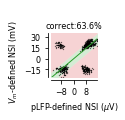

In [37]:
from scipy.optimize import minimize

def make_check_plot(data, xlim=[-15,15], ylim=[-25,35], noise_factor=1.5, noise_tol = 2.85):
    fig, ax = figure(figsize=(.12,.08))
    noise_tol = noise_factor*data['p0']
    x, y = np.array(data['NSI'][data['NSI_validated']]), np.array(data['Vm_NSI'][data['NSI_validated']])
    ax.plot(x[::2], y[::2], 'k.', ms=0.5)
    ax.plot(xlim, ylim, 'w.', ms=0.005) # just ot have the limits on all plots
    correct_percent, func, p = get_correct_percentage(data, xlim=[-15,15], ylim=[-25,35], noise_tol=noise_tol)       
    ax.plot(xlim, func(np.array(xlim), p), '-', lw=1, color=Green)
    ax.annotate('correct:'+str(round(correct_percent,1))+'%', (-.1, 1.1), xycoords='axes fraction', fontsize=FONTSIZE)
    ax.fill_between([2*xlim[0], 2*xlim[1]],
                    func(np.array([2*xlim[0]-noise_tol, 2*xlim[1]-noise_tol]), p),
                    func(np.array([2*xlim[0]+noise_tol, 2*xlim[1]+noise_tol]), p),
                    color=Green, alpha=.2, lw=0)
    y1, y2 = ax.get_ylim()                             
    ax.fill_between([2*xlim[0]+noise_tol, 2*xlim[1]], y1*np.ones(2),
                    func(np.array([2*xlim[0], 2*xlim[1]-noise_tol]), p), color=Red, alpha=.2, lw=0)
    ax.fill_between([xlim[0]-noise_tol, xlim[1]], y2*np.ones(2), func(np.array([xlim[0], xlim[1]+noise_tol]), p), color=Red, alpha=.2, lw=0)
    set_plot(ax, xlabel='pLFP-defined NSI ($\mu$V)', ylabel='$V_m$-defined NSI (mV)      ', xlim=xlim, ylim=ylim)
    return fig, ax, correct_percent
make_check_plot(DATA[-4], noise_tol=3.);

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


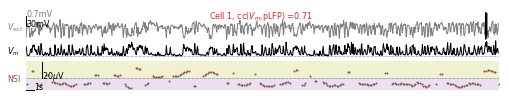

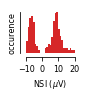

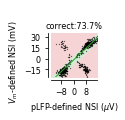

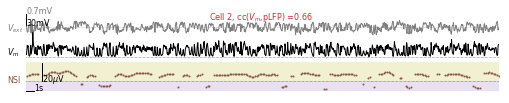

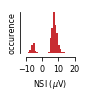

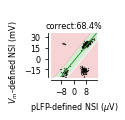

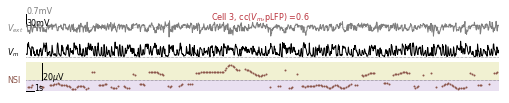

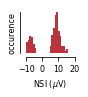

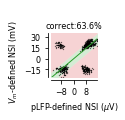

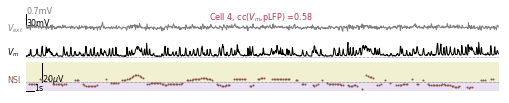

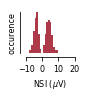

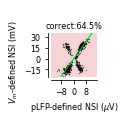

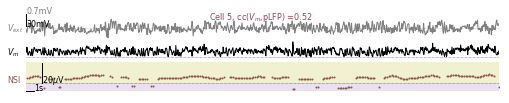

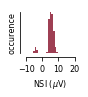

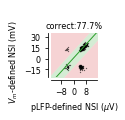

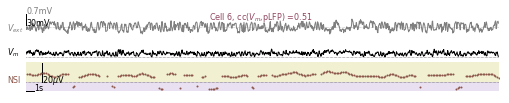

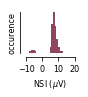

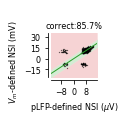

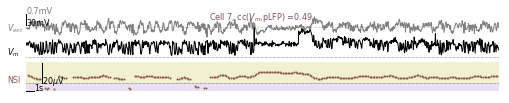

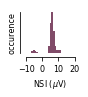

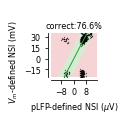

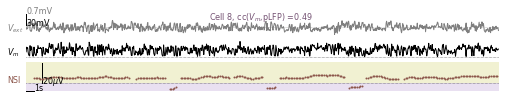

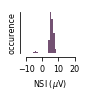

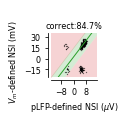

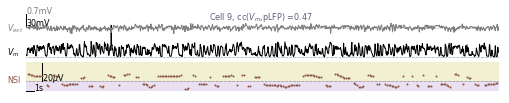

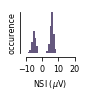

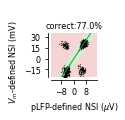

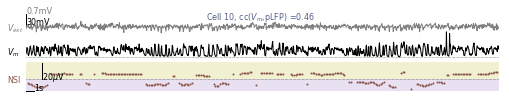

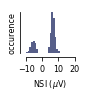

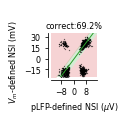

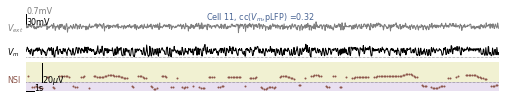

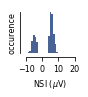

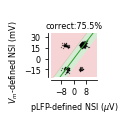

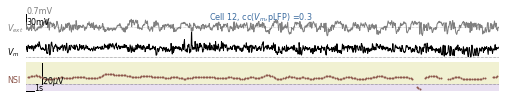

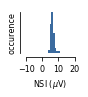

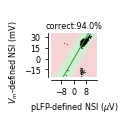

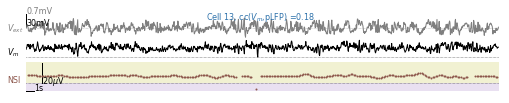

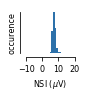

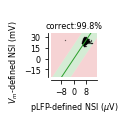

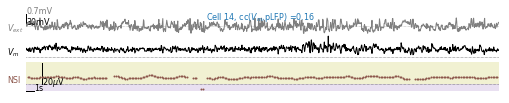

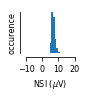

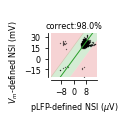

In [38]:
#from cortical_arousal_index.plots import *

colormap = get_linear_colormap(Red, Blue)

# prepare histogram
def make_hist(data, bins=np.linspace(-10,20,30), color='k'):
    fig, ax = figure(figsize=(.14,.08))
    ax.hist(data['NSI'][data['NSI_validated']], bins=bins, normed=True, lw=0, facecolor=color)
    set_plot(ax, xlabel='NSI ($\mu$V)', ylabel='occurence', yticks=[])
    return fig


FIGS1, FIGS2, FIGS3 = [], [], []
P1, P2 = [], []
# now loop over cells
for k, i in enumerate(np.arange(len(DATA))[cc_ordered]):
    fig_cell, _ = show_raw_data_large_scale(DATA[i], tstart=30, twidth=60, subsampling=1000,
                                         Tbar=1, NSI_bar=20, NSI_bar_loc=(2,0))
    fig_cell.suptitle('Cell '+str(k+1)+', cc($V_m$,pLFP) ='+str(round(DATA[i]['cc-Vm-pLFP'],2)),
                      color=colormap(k/(len(order)-1.)), fontsize=FONTSIZE)
    fig_cell2 = make_hist(DATA[i], color=colormap(k/(len(DATA)-1.)))
    fig_cell3, _, percent1 = make_check_plot(DATA[i])
    P1.append(percent1)
    FIGS1.append(fig_cell)
    FIGS2.append(fig_cell2)    
    FIGS3.append(fig_cell3)    

In [39]:
print('final percentage correct:', round(np.mean(P1),1), round(np.std(P1),1))

final percentage correct: 79.2 11.4


## Making the figure for all cells

In [304]:
PARAMS = [{} for i in range(8)]
FIGS1 = [None for i in range(8)]
FIGS2 = [None for i in range(8)]
FIGS3 = [None for i in range(8)]
length = 60.
colormap = get_linear_colormap(Orange, Blue)

In [40]:
k, i0 = 0, 13
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(8,-65), 'LFP_loc':-30,
             'LFP_bar':0.6, 'NSI_bar':10,  'NSI_bar_loc':(8,10)}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
fig_cell.suptitle('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)),
                  color=colormap(k/(len(order)-1.)), fontsize=FONTSIZE)
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere(xx*yy>0).flatten()[:1]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

NameError: name 'PARAMS' is not defined

In [ ]:
k, i0 = 1, 12
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(8,-65), 'LFP_loc':-20,
             'LFP_bar':0.4, 'NSI_bar':10,  'NSI_bar_loc':(8,10)}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
fig_cell.suptitle('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)),
                  color=colormap(cc_ordered[i0]/(len(order)-1.)), fontsize=FONTSIZE)
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy<0) & (tt>PARAMS[k]['tstart']+40)).flatten()[:1]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

In [ ]:
k, i0 = 2, 11
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(4,-69), 'LFP_loc':-20,
             'LFP_bar':0.2, 'NSI_bar':10,  'NSI_bar_loc':(8,10)}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
fig_cell.suptitle('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)),
                  color=colormap(cc_ordered[i0]/(len(order)-1.)), fontsize=FONTSIZE)
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy>0) & (tt>PARAMS[k]['tstart']+28)).flatten()[1]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

In [ ]:
k, i0 = 3, 9
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-10), 'LFP_loc':-20,
             'LFP_bar':0.5, 'NSI_bar':10,  'NSI_bar_loc':(8,10)}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
fig_cell.suptitle('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)),
                  color=colormap(cc_ordered[i0]/(len(order)-1.)), fontsize=FONTSIZE)
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy<0) & (xx<0) & (tt>PARAMS[k]['tstart']+10)).flatten()[0]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

In [ ]:
k, i0 = 4, 8
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-30), 'LFP_loc':-40,
             'LFP_bar':0.5, 'NSI_bar':10,  'NSI_bar_loc':(3,10)}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
fig_cell.suptitle('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)),
                  color=colormap(cc_ordered[i0]/(len(order)-1.)), fontsize=FONTSIZE)
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy>0) & (xx>0) & (tt>PARAMS[k]['tstart']+10)).flatten()
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

In [ ]:
k, i0 = 5, 5
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-10), 'LFP_loc':-20,
             'LFP_bar':0.3, 'NSI_bar':10,  'NSI_bar_loc':(3,10)}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
fig_cell.suptitle('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)),
                  color=colormap(cc_ordered[i0]/(len(order)-1.)), fontsize=FONTSIZE)
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy<0) & (xx>0) & (tt>PARAMS[k]['tstart']+17)).flatten()[0]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

In [ ]:
k, i0 = 6, 3
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-10), 'LFP_loc':-20,
             'LFP_bar':0.3, 'NSI_bar':10,  'NSI_bar_loc':(3,10)}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
fig_cell.suptitle('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)),
                  color=colormap(cc_ordered[i0]/(len(order)-1.)), fontsize=FONTSIZE)
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy<0) & (xx>0) & (tt>PARAMS[k]['tstart']+17)).flatten()[0]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

In [ ]:
k, i0 = 7, 0
PARAMS[k] = {'tstart':20., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-5), 'LFP_loc':-20,
             'LFP_bar':0.4, 'NSI_bar':10,  'NSI_bar_loc':(3,10)}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
fig_cell.suptitle('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)),
                  color=colormap(cc_ordered[i0]/(len(order)-1.)), fontsize=FONTSIZE)
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx<0) & (tt>PARAMS[k]['tstart'])).flatten()[0]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

In [ ]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig(FIGS1+FIGS2+FIGS3,
                            fig_name='paper/Figures/Fig_All_cells.svg',
                            figsize=(0.9,0.1*len(FIGS1)),
                            Props={'XCOORD':[-10 for i in range(len(FIGS1))]+\
                                   [490 for i in range(len(FIGS2))]+\
                                   [620 for i in range(len(FIGS3))],
                                   'YCOORD':[100*i for i in range(len(FIGS1))]+\
                                   [100*i+9 for i in range(len(FIGS2))]+\
                                   [100*i+9 for i in range(len(FIGS3))]},
                            visualize=False)
#plt.close('all')

In [317]:
export_as_png(os.getcwd()+'/paper/Figures/Fig_All_cells.svg', dpi=100)

In [41]:
from IPython.display import Image
#Image(filename='paper/Figures/Fig_All_cells.png', width=300)

<IPython.core.display.Image object>

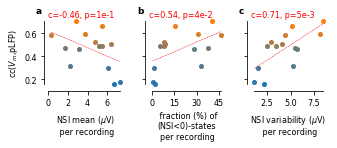

In [321]:
# Correlation between 
fig, AX = figure(axes=(1, 3), figsize=(0.5, 0.13), wspace=0.8, left=0.1)

mean_nsi, std_nsi, std_pos_nsi, fraction_lf, cc = [], [], [], [], []
# now loop over cells
for k, i in enumerate(np.arange(len(DATA))[cc_ordered]):
    x = DATA[i]['NSI'][DATA[i]['NSI_validated']]
    mean_nsi.append(np.mean(x))
    std_nsi.append(np.std(x))
    std_pos_nsi.append(np.std(x[x>0]))
    fraction_lf.append(len(DATA[i]['NSI'][(DATA[i]['NSI_validated']) & (DATA[i]['NSI']<0)])/len(x))
    cc.append(DATA[i]['cc-Vm-pLFP'])
    AX[0][0].plot([mean_nsi[-1]], [cc[-1]], 'o', color=colormap(k/(len(DATA)-1.)), ms=4)
    AX[0][2].plot([std_nsi[-1]], [cc[-1]], 'o', color=colormap(k/(len(DATA)-1.)), ms=4)
    AX[0][1].plot([100.*fraction_lf[-1]], [cc[-1]], 'o', color=colormap(k/(len(DATA)-1.)), ms=4)
from scipy.stats import pearsonr
for x, ax in zip([np.array(mean_nsi), 100.*np.array(fraction_lf), np.array(std_nsi)], AX[0]):
    c, p = pearsonr(x, cc)    
    ax.plot([x.min(), x.max()], np.polyval(np.polyfit(x, cc, 1),[x.min(), x.max()]), 'r--', lw=0.5)
    ax.annotate('c='+str(round(c,2))+', p='+sci_str(p), (0.01,.99), xycoords='axes fraction',  color='r', fontsize=FONTSIZE)
for l, ax in zip(['a', 'b', 'c'], AX[0]):
    ax.annotate(l, (-0.15,1.05), xycoords='axes fraction',  fontsize=FONTSIZE+1, fontweight='bold')
set_plot(AX[0][0], xlabel='NSI mean ($\mu$V)\n per recording', ylabel='cc($V_m$,pLFP)', yticks=[0.2,0.4,0.6])
set_plot(AX[0][1], xlabel=' fraction (%) of\n(NSI<0)-states\nper recording', yticks=[0.2,0.4,0.6], yticks_labels=[])
set_plot(AX[0][2], xlabel='NSI variability ($\mu$V)\n per recording', yticks=[0.2,0.4,0.6], yticks_labels=[])
fig.savefig('paper/Figures/Fig_Link_NSI_Correl.svg')
#export_as_png(os.getcwd()+'/paper/Figures/Fig_Link_NSI_Correl.svg', dpi=300)

# Limitations

In [1]:
# let's do the same based on the Vm recordings and compare the two
%run cortical_arousal_index/exp_data.py
DATASET = get_one_dataset('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type')

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## LOAD ALL DATASET
DATA = []
for i in np.arange(len(DATASET)):
    data = load_data(DATASET[i]['files'][0], args, full_processing=True)
    # compute the Network State Index
    functions.compute_Network_State_Index(data, key='sbsmpl_Vm', target_key='Vm_NSI', p0_key='p0_Vm',
                                          Tstate=args.Tstate,
                                          Var_criteria=1000, # NOT USED, WE USE THE VALIDATION OF pLFP !!
                                          alpha=args.alpha,
                                          T_sliding_mean=args.T_sliding_mean)
    
    DATA.append(data)
    # DATA[i]['cc-Vm-LFP'] = np.corrcoef(DATA[i]['sbsmpl_Vm'], DATA[i]['sbsmpl_Extra'])[0,1]
    # DATA[i]['cc-Vm-pLFP'] = np.corrcoef(DATA[i]['sbsmpl_Vm'], DATA[i]['pLFP'])[0,1]        

correct fraction: 69
0 correl: (0.5077627788077339, 8.344748326802096e-71)
correct fraction: 71
1 correl: (0.5384134711434053, 1.3825211610790765e-189)
correct fraction: 74
2 correl: (0.7354057304088462, 1.8478842184900618e-244)
correct fraction: 86
3 correl: (0.41323829227211517, 4.8890537439428056e-46)


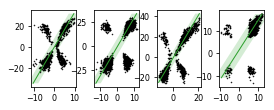

In [24]:
noise_factor = 1.

from scipy.stats import pearsonr
import matplotlib.patches as patches
fig, AX = figure(figsize=(.15*len(DATA), 0.14), axes=(1, len(DATA)))
for i in range(len(DATA)):
def make_check_plot(data, xlim=[-15,15], ylim=[-20,30]):
    noise_tol = noise_factor+data['p0']
    x, y = np.array(data['NSI'][data['NSI_validated']]), np.array(data['Vm_NSI'][data['NSI_validated']])
    AX[0][i].plot(x, y, 'ko', ms=0.5)
    pol = np.polyfit(x[(x*y)>=0], y[(x*y)>=0], 1)
    AX[0][i].plot(xlim, np.polyval(pol, xlim), '-', lw=1, color=Green)
    AX[0][i].add_patch(patches.Polygon(xy=list(zip([xlim[0]-noise_tol, xlim[0]+noise_tol,
                                                    xlim[1]+noise_tol, xlim[1]-noise_tol],
                                                   np.polyval(pol, [xlim[0], xlim[0], xlim[1], xlim[1]]))),
                                       fill=True, color=Green, lw=0, alpha=.2))
    correct_cond = (y>=np.polyval(pol, x-noise_tol)) & (y<=np.polyval(pol, x+noise_tol))
    print('correct fraction:', round(100.*len(x[correct_cond])/len(x),1))
    print(i, 'correl:', pearsonr(x, y))

0 correl: (0.4578803972522619, 2.4557673611416968e-57)
1 correl: (0.5620058450568272, 2.4633297386657988e-208)
2 correl: (0.6821686064412424, 6.882594701143787e-201)
3 correl: (0.40375986190517477, 3.2259803416851213e-43)


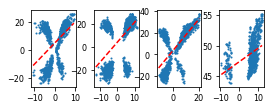

In [16]:
from scipy.stats import pearsonr
fig, AX = figure(figsize=(.15*len(DATA), 0.14), axes=(1, len(DATA)))
for i in range(len(DATA)):
    x, y = np.array(DATA[i]['NSI'][DATA[i]['NSI_validated']]), np.array(DATA[i]['Vm_NSI'][DATA[i]['NSI_validated']])
    AX[0][i].plot(x, y, 'o', ms=0.5)
    AX[0][i].plot([x.min(), x.max()], np.polyval(np.polyfit(x, y, 1), [x.min(), x.max()]), 'r--')
    print(i, 'correl:', pearsonr(x, y))

# Wavelet analysis

In [22]:
"""
Wavelet functions can be found in the 'functions' module
"""
from cortical_arousal_index.functions import *

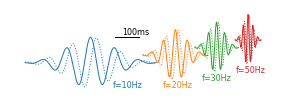

In [23]:
fig1, ax = figure(figsize=(.46,.1), bottom=0.02, left=0.02)     
for i, f, xshift, xshift2, yshift2, yshift in zip(
        range(4), [10., 20,  30., 50.],
        [0, 3.5, 5.2, 6.5],
        [0.9, 3., 4.6, 6],
        [0., 0., 0.3, .6],
        np.arange(4)*.3):
    t, wvl = get_Morlet_of_right_size(f, 1e-3, with_t=True)
    ax.plot(t+.1*xshift, yshift+np.real(wvl),
         c='C'+str(i), lw=1)
    ax.plot(t+.1*xshift, yshift+np.imag(wvl), c='C'+str(i), ls=':',
            lw=1)
    ax.annotate('f='+str(int(f))+'Hz', (.1*xshift2, yshift2-1), color='C'+str(i), fontsize=FONTSIZE)
ax.plot([.1,.2], [1,1], 'k-', lw=1)
ax.annotate('100ms', (.13, 1.1), fontsize=FONTSIZE)    
set_plot(plt.gca(), [])
fig1.savefig('paper/Figures/wavelets_vis.svg')

## Finding the right normalization for CWT

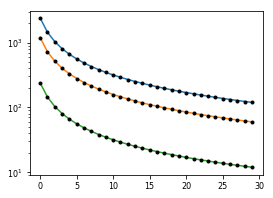

In [24]:
# let's check that the norm matches the numerical estimate

def norm_constant_num(freq, dt, w0=6.):
    Tmax = Morlet_Wavelet_Decay(freq, w0=w0)
    t = np.arange(-int(Tmax/dt), int(Tmax/dt)+1)*dt
    return np.abs(np.dot(np.cos(2.*np.pi*freq*t),\
                         np.conj(get_Morlet_of_right_size(freq, dt, w0=w0))))

fig, ax = figure(figsize=(.6,.3))
for dt in [1e-4, 2e-4, 1e-3]:
    ax.semilogy([norm_constant_th(f, dt, w0=6.) for f in np.linspace(5, 100, 30)])
    ax.semilogy([norm_constant_num(f, dt, w0=6.) for f in np.linspace(5, 100, 30)], 'ko', ms=3)

In [25]:
noise_level = 0.
nfreq = 100

# temporal sampling
dt, tstop = 1e-3, 2.1
t = np.arange(int(tstop/dt))*dt

# ### artificially generated signal, transient oscillations
freq1, onset1, width1, amp1 = 40., 200e-3, 50e-3, 2.
freq2, onset2, width2, amp2 = 10., 700e-3, 150e-3, 2.
freq3, onset3, width3, amp3 = 60., 1200e-3, 50e-3, 2.
freq4, onset4, width4, amp4 = 40., 1700e-3, 150e-3, 1.
baseline = 0.
data  = baseline+\
    amp1*np.cos(2*np.pi*freq1*t)*np.exp(-(t-onset1)**2/2./width1**2)+\
    amp2*np.cos(2*np.pi*freq2*t)*np.exp(-(t-onset2)**2/2./width2**2)+\
    amp3*np.cos(2*np.pi*freq3*t)*np.exp(-(t-onset3)**2/2./width3**2)+\
    amp4*np.cos(2*np.pi*freq4*t)*np.exp(-(t-onset4)**2/2./width4**2)

# ### adding colored noise to test robustness
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/400e-3),\
                    np.random.randn(len(t)), mode='same') # a slow one
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/5e-3),\
                    np.random.randn(len(t)), mode='same') # a faster one

# Continuous Wavelet Transform analysis
freqs = np.linspace(1, 95, nfreq)
coefs = my_cwt(data, freqs, dt)

amp = np.abs(coefs)
cond = np.abs(coefs)<np.max(np.abs(coefs))*0.1
phase = np.angle(coefs)
phase[cond] = np.inf

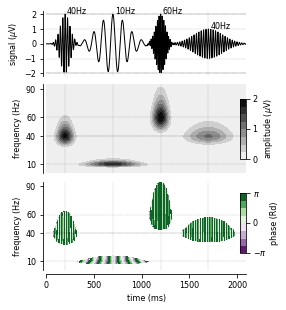

In [26]:
"""
a plot to illustrate the output of the wavelet analysis
"""
colormap=mpl.cm.binary
fig2, AX = figure(figsize=(0.46,0.36),
                 hspace=1.1, bottom=0.35, right=.9, left=.45,
                 axes_extents=[[[1,3]],[[1,4]], [[1,4]]])
# signal plot
plot(1e3*t, data, c='k', lw=1, ax=AX[0][0],\
     axes_args={'ylabel':'signal ($\mu$V)',
                'xlim':[1e3*t[0], 1e3*t[-1]],
                'yticks':baseline+np.arange(-2,3),
                'spines':['left']})
yyl = AX[0][0].get_ylim()
for f, a, tt in zip([freq1, freq2, freq3, freq4],\
                    [amp1, amp2, amp3, amp4],
                    [onset1, onset2, onset3, onset4]):
    AX[0][0].annotate(str(int(f))+'Hz', (1e3*tt+20, a+baseline), fontsize=FONTSIZE)
    AX[0][0].plot(1e3*tt+np.zeros(2), yyl, 'k:', lw=.2)
    for ax in [AX[1][0], AX[2][0]]:
        ax.plot(1e3*np.arange(2)*t[-1], [f, f], 'k:', lw=.2)
        ax.plot(1e3*tt+freqs*0, freqs, 'k:', lw=.2)
    AX[0][0].plot(1e3*np.arange(2)*t[-1], [a, a], 'k:', lw=.2)
    AX[0][0].plot(1e3*np.arange(2)*t[-1], [-a, -a], 'k:', lw=.2)

# time frequency power plot
c = AX[1][0].contourf(1e3*t, freqs, amp, cmap=colormap)
set_plot(AX[1][0], ['left'], xlim=[1e3*t[0], 1e3*t[-1]],
         ylabel='frequency (Hz)', yticks=[freq1, freq2, freq3, 90])

# inset with legend
acb = plt.axes([.85, .48, .02, .2])
cb = plt.colorbar(c, cax=acb, label='amplitude ($\mu$V)')
cb.set_ticks([0, 1, 2, 3])

# time frequency phase plot
c = AX[2][0].contourf(1e3*t, freqs, phase, cmap='PRGn')
set_plot(AX[2][0], xlim=[1e3*t[0], 1e3*t[-1]],
         xlabel='time (ms)', xticks=np.arange(5)*500,
         ylabel='frequency (Hz)', yticks=[freq1, freq2, freq3, 90])

# inset with legend
acb = plt.axes([.85, .17, .02, .2])
cb = plt.colorbar(c, cax=acb, label='phase (Rd)')
cb.set_ticks([-np.pi, 0, np.pi])
cb.set_ticklabels(['$-\pi$', '0', '$\pi$'])

In [28]:
from graphs.plot_export import put_list_of_figs_to_svg_fig
put_list_of_figs_to_svg_fig([fig1, fig2],
                            fig_name='paper/Figures/Fig_Wavelet_Demo.svg',
                            figsize=(0.335,0.34),
                            Props={'XCOORD':[-2,-5],
                                   'YCOORD':[-5,84],
                                   'XCOORD_LABELS':[-5, -5],
                                   'YCOORD_LABELS':[10, 78],
                                   'LABELS':['a','b']},
                            visualize=False)
export_as_png(os.getcwd()+'/paper/Figures/Fig_Wavelet_Demo.svg', dpi=100)

In [44]:
from IPython.display import Image
#Image(filename='paper/Figures/Fig_Wavelet_Demo.png', width=300)

# A quick draft of the analysis

In [370]:
"""
Loading a sample datafile for the awake
"""
from data_analysis.IO.load_data import load_file
data = load_file('../sparse_vs_balanced/'+\
                 'sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf')
cond = (data[0]>100) & (data[0]<200)
data_awake={'t':data[0][cond], 'Vm':data[1][1][cond], 'Extra':data[1][0][cond]}
data_awake['dt'] = data_awake['t'][1]-data_awake['t'][0]

from graphs.my_graph import *
from scipy.integrate import cumtrapz

def get_max_of_hist(data, nbins=300, smoothing=2):
    """
    maybe need to get more complex to identify the first maximum
    (e.g. Up and Down states case) 
    """
    binsize = (data['pLFP'].max()-data['pLFP'].min())/nbins
    Hist, be = np.histogram(data['pLFP'],
                            bins=np.concatenate([
                                np.arange(-2*smoothing,0)*binsize+data['pLFP'].min(),
                                np.arange(nbins)*binsize+data['pLFP'].min(),
                                np.arange(0,2*smoothing)*binsize+data['pLFP'].max()
                            ]), normed=True)
    i0 = np.argmax(gaussian_smoothing(Hist,smoothing))
    data['max_of_hist']=be[i0+1]
    data['noise_estimate']=np.std(data['pLFP'][data['pLFP']<data['max_of_hist']])
    data['hist_amp']=Hist[i0]
    return {'max_of_hist':be[i0],
            'noise_estimate':be[i0]-data['pLFP'].min(),
            'hist_amp':Hist[i0]}

get_max_of_hist(data_awake)


(<matplotlib.figure.Figure at 0x1a0f85d6d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a0f85dc50>)

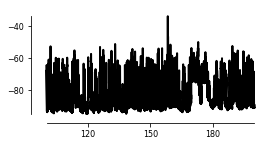

In [3]:
plot(data_awake['t'][::100], data_awake['Vm'][::100], fig_args=dict(figsize=(.6,.2)))

(<matplotlib.figure.Figure at 0x1a0f88ea58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a0f881550>)

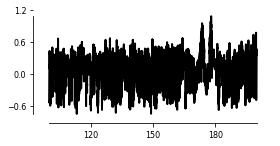

In [4]:
plot(data_awake['t'][::100], data_awake['Extra'][::100], fig_args=dict(figsize=(.6,.2)))

In [371]:
from data_analysis.processing.signanalysis import gaussian_smoothing

def preprocess_LFP(data,
                   freqs = np.linspace(50, 300, 5),
                   new_dt = 5e-3, smoothing=20e-3, pLFP_unit='$\mu$V'):
    """
    performs continuous wavelet transform
    """
    data['W'] = my_cwt(data['Extra'], freqs, data['dt'])
    data['pLFP_freqs'] = freqs
    W2 = np.abs(data['W']).mean(axis=0)
    isubsmpl = int(round(new_dt/data['dt']))
    data['pLFP'] = gaussian_smoothing(\
                                      np.reshape(W2[:int(len(W2)/isubsmpl)*isubsmpl],
                                                 (int(len(W2)/isubsmpl),isubsmpl)).mean(axis=1),
                                      int(smoothing/new_dt))
    
    data['pLFP_unit']=pLFP_unit
    if pLFP_unit=='$\mu$V':
        data['pLFP'] *= 1e3
        
    data['new_t'] = np.arange(len(data['pLFP']))*new_dt+data['t'][0]
    data['new_indices'] = np.arange(len(data['pLFP']))*isubsmpl
    data['new_Vm'] = data['Vm'][data['new_indices']]
    data['new_Extra'] = data['Extra'][data['new_indices']]
    
    data['new_dt'] = new_dt
    
preprocess_LFP(data_awake)        

### Illustrating the output of the analysis

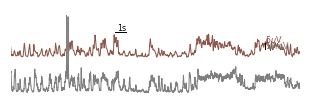

In [372]:
t0, width = 153.5, 25
spikes=-30
vm_color=Grey
pLFP_color=Brown
Vm_bar = 10
pLFP_bar=5
T_bar=1.
pLFP_loc=-45

cond = (data_awake['new_t']>t0) & (data_awake['new_t']<t0+width)
fig_with_pLFP, ax = figure(figsize=(.5,.15), left=.01, bottom=.1)
ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax.plot(data_awake['new_t'][cond],
        data_awake['pLFP'][cond].mean()+data_awake['pLFP'][cond]/pLFP_bar*Vm_bar+pLFP_loc,
        '-', lw=1, color=pLFP_color)
cond = cond & (data_awake['new_Vm']<spikes)
ax.plot(data_awake['new_t'][cond], data_awake['new_Vm'][cond], '-', color=vm_color, lw=1)
cond0 = (data_awake['t']>t0) & (data_awake['t']<t0+width)
i0 = np.argwhere((data_awake['Vm'][cond0][1:]>spikes) & (data_awake['Vm'][cond0][:-1]<=spikes)).flatten()
for ii in i0:
    ax.plot(data_awake['t'][cond0][ii-100:ii+100], data_awake['Vm'][cond0][ii-100:ii+100], '-', color=vm_color, lw=1)
# ax.plot([data_awake['new_t'][cond][0], data_awake['new_t'][cond][-1]], pLFP_loc*np.ones(2), ':', color=pLFP_color, lw=1)
# ax.plot([data_awake['new_t'][cond][0], data_awake['new_t'][cond][-1]], -50*np.ones(2), ':', color=vm_color, lw=1)
# Tbar
ax.plot([data_awake['new_t'][cond][0]+T_bar+8, data_awake['new_t'][cond][0]+2*T_bar+8], [10, 10], 'k-', lw=1)
ax.annotate(str(int(T_bar))+'s', (data_awake['new_t'][cond][0]+T_bar+8+.2, 11), fontsize=FONTSIZE)
# Vm-LFP bar
ax.plot([data_awake['new_t'][cond][-1]-3*T_bar, data_awake['new_t'][cond][-1]-3*T_bar], [pLFP_loc/5, pLFP_loc/5-Vm_bar], 'k-', lw=1)
ax.annotate(str(int(Vm_bar))+'mV', (data_awake['new_t'][cond][-1]-3*T_bar, pLFP_loc/5-Vm_bar), fontsize=FONTSIZE, color=vm_color)
ax.annotate(str(int(pLFP_bar))+'$\mu$V', (data_awake['new_t'][cond][-1]-3*T_bar, pLFP_loc/5),
            fontsize=FONTSIZE, color=pLFP_color)
set_plot(ax, [], xlim=[data_awake['new_t'][cond][0], data_awake['new_t'][cond][-1]], xticks=[], yticks=[])

#fig.savefig(desktop+'fig.svg')

### Looking for the best frequency content

In [422]:
DISCRET = 6
WAVELET_NUM = 5
CENTER_FREQUENCIES = np.logspace(0,3,DISCRET)
BAND_LENGTH_FACTOR = np.linspace(1.01,4.,DISCRET)

CROSS_CORRELS = np.zeros((len(CENTER_FREQUENCIES), len(BAND_LENGTH_FACTOR)))

for i, cf in enumerate(CENTER_FREQUENCIES):
    for j, blf in enumerate(BAND_LENGTH_FACTOR):
        preprocess_LFP(data_awake, freqs=np.linspace(cf/blf, cf*blf, WAVELET_NUM))        
        CROSS_CORRELS[i,j] = np.abs(np.corrcoef(data_awake['new_Vm'], data_awake['pLFP']))[0,1]

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


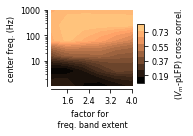

In [109]:
fig_optimum, ax = figure(right=.9)
p = plt.contourf(BAND_LENGTH_FACTOR, CENTER_FREQUENCIES,
                 np.array(CROSS_CORRELS),
                 levels=np.linspace(np.min(CROSS_CORRELS), np.max(CROSS_CORRELS),20),
                 cmap=copper)
ax.set_yscale('log')
set_plot(ax, xlabel='factor for \n freq. band extent', ylabel='center freq. (Hz)',
         yticks=[10,100,1000], yticks_labels=['10','100','1000'])
acb = plt.axes([.9,.35,.05,.5])
build_bar_legend(np.round(np.linspace(np.min(CROSS_CORRELS), np.max(CROSS_CORRELS),5),2),
                 acb, copper,
                 color_discretization=10,
                 label='($V_m$-pLFP) cross correl.')

### Looking for the optimal number of wavelets

In [124]:
WAVELET_NUM = np.concatenate([[1], np.arange(1, 6)*3])
CENTER_FREQUENCIES = 100
BAND_LENGTH_FACTOR = 2.

CROSS_CORRELS = np.zeros(len(WAVELET_NUM))
COMP_TIME = np.zeros(len(WAVELET_NUM))

import time
for i, wv in enumerate(WAVELET_NUM):
    start_time = time.time()
    preprocess_LFP(data_awake, freqs=np.linspace(CENTER_FREQUENCIES/BAND_LENGTH_FACTOR, CENTER_FREQUENCIES*BAND_LENGTH_FACTOR, wv))        
    COMP_TIME[i] = time.time() - start_time
    CROSS_CORRELS[i] = np.abs(np.corrcoef(data_awake['new_Vm'], data_awake['pLFP']))[0,1]

Text(0,0.5,'comp. time (s)')

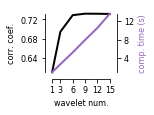

In [145]:
fig_comp_ressource, ax = figure(figsize=(.17,.12))
ax.plot(WAVELET_NUM, CROSS_CORRELS, color='k', lw=2)
ax2 = ax.twinx()
ax2.plot(WAVELET_NUM, COMP_TIME, color=Purple, lw=2)
set_plot(ax2, ['right'], xticks=WAVELET_NUM)
set_plot(ax, ['left', 'bottom'], ylabel='corr. coef.',
         xticks=WAVELET_NUM, xlabel='wavelet num.')
ax2.set_ylabel('comp. time (s)', color=Purple, fontsize=FONTSIZE)

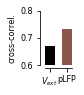

In [150]:
bottom=.6
fig_Vext_pLFP, ax = figure(figsize=(.08,.1))
ax.bar([0], [np.abs(np.corrcoef(data_awake['new_Vm'], data_awake['new_Extra']))[0,1]-bottom],
       bottom=bottom,width=.6, color='k')
ax.bar([1], [np.abs(np.corrcoef(data_awake['new_Vm'], data_awake['pLFP']))[0,1]-bottom],
       bottom=bottom, width=.6, color=Brown)
set_plot(ax, xticks=[0,1], xticks_labels=['$V_{ext}$', 'pLFP'], ylabel='cross-correl.', yticks=[.6,.7,.8])

In [155]:
from graphs.plot_export import put_list_of_figs_to_svg_fig
put_list_of_figs_to_svg_fig([fig_optimum, fig_comp_ressource, fig_Vext_pLFP,fig_with_pLFP],
                            fig_name='paper/Figures/Fig_pLFP_Comput.svg',
                            figsize=(0.5,0.2),
                            Props={'XCOORD':[0,200,340,10],
                                   'YCOORD':[10, 10, 130, 130],
                                   'LABELS':['a','b','d','c']},
                            visualize=True)

In [23]:
"""
Loading a sample datafile for the anesthetized
"""
from data_analysis.IO.load_data import load_file
data = load_file(home+'DATA/Data_Ste_Zucca/2017_04_04/14_40_12_CCLAMP-WITH-CORTEX-EXTRA.h5')
cond = (data['t']>300) & (data['t']<400)
data_anesth={'t':data['t'][cond], 'Vm':data['Vm'][cond], 'Extra':data['ExtraCort'][cond]}
data_anesth['dt'] = data_anesth['t'][1]-data_anesth['t'][0]

In [597]:
from data_analysis.processing.signanalysis import gaussian_smoothing

def preprocess_LFP(data,
                   freqs = np.linspace(50, 300, 5),
                   new_dt = 5e-3, smoothing=20e-3, pLFP_unit='$\mu$V'):
    """
    performs continuous wavelet transform
    """
    data['W'] = my_cwt(data['Extra'], freqs, data['dt'])
    data['pLFP_freqs'] = freqs
    W2 = np.abs(data['W']).mean(axis=0)
    isubsmpl = int(round(new_dt/data['dt']))
    data['pLFP'] = gaussian_smoothing(\
                                      np.reshape(W2[:int(len(W2)/isubsmpl)*isubsmpl],
                                                 (int(len(W2)/isubsmpl),isubsmpl)).mean(axis=1),
                                      int(smoothing/new_dt))
    
    data['pLFP_unit']=pLFP_unit
    if pLFP_unit=='$\mu$V':
        data['pLFP'] *= 1e3
        
    data['new_t'] = np.arange(len(data['pLFP']))*new_dt+data['t'][0]
    data['new_dt'] = new_dt
    
#preprocess_LFP(data_anesth)
preprocess_LFP(data_awake)        

In [373]:
def plot_three_quant(data, tstart=-np.inf, tend=np.inf):
    cond = (data['t']>tstart) & (data['t']<tend)
    fig, AX = figure(axes=(3,1),figsize=(1.6,.4), hspace=.01)
    plot(data['t'][cond], data['Extra'][cond], ax=AX[0][0],
         axes_args={'ylabel':'$V_{ext}$ (mV)',
                    'xlim':[data['t'][cond][0], data['t'][cond][-1]], 'spines':['left']});
    plot(data['t'][cond], data['Vm'][cond], ax=AX[1][0],
         axes_args={'xlabel':'time (s)', 'ylabel':'$V_m$ (mV)',
                    'xlim':[data['t'][cond][0], data['t'][cond][-1]], 'spines':['left']});
    cond = (data['new_t']>tstart) & (data['new_t']<tend)
    plot(data['new_t'][cond], data['pLFP'][cond], ax=AX[2][0],
         axes_args={'xlabel':'time (s)', 'ylabel':'pLFP ('+data['pLFP_unit']+')',
                    'xlim':[data['new_t'][cond][0], data['new_t'][cond][-1]]}, c=Red);

In [375]:
plot_three_quant(data_anesth)

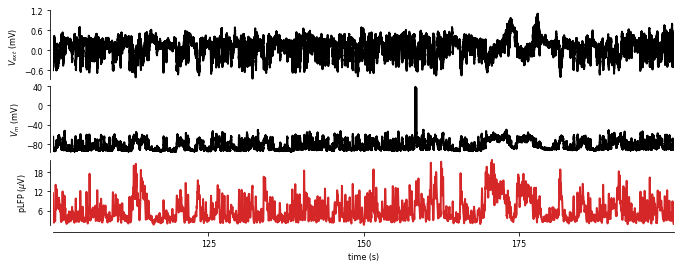

In [376]:
plot_three_quant(data_awake)

## Finding the level of ~quiescent activity

In [377]:
from graphs.my_graph import *
from scipy.integrate import cumtrapz

def get_max_of_hist(data, nbins=300, smoothing=2):
    """
    maybe need to get more complex to identify the first maximum
    (e.g. Up and Down states case) 
    """
    binsize = (data['pLFP'].max()-data['pLFP'].min())/nbins
    Hist, be = np.histogram(data['pLFP'],
                            bins=np.concatenate([
                                np.arange(-2*smoothing,0)*binsize+data['pLFP'].min(),
                                np.arange(nbins)*binsize+data['pLFP'].min(),
                                np.arange(0,2*smoothing)*binsize+data['pLFP'].max()
                            ]), normed=True)
    i0 = np.argmax(gaussian_smoothing(Hist,smoothing))
    data['max_of_hist']=be[i0+1]
    data['noise_estimate']=np.std(data['pLFP'][data['pLFP']<data['max_of_hist']])
    data['hist_amp']=Hist[i0]
    return {'max_of_hist':be[i0],
            'noise_estimate':be[i0]-data['pLFP'].min(),
            'hist_amp':Hist[i0]}

get_max_of_hist(data_awake)

{'hist_amp': 0.2362921240957489,
 'max_of_hist': 3.2418137739307555,
 'noise_estimate': 1.6929045034017143}

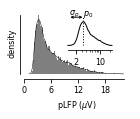

In [378]:
from graphs.my_graph import *
def show_histogram_of_pLFP(data, nbins=300, smoothing=2, XLIM=[3,24]):
    fig, ax = figure(figsize=(.19,.12), left=.4, bottom=1, right=1.1)
    hist(data['pLFP'], ax=ax, bins=nbins, normed=True, lw=0, facecolor=Grey)
    binsize = (data['pLFP'].max()-data['pLFP'].min())/nbins
    Hist, be = np.histogram(data['pLFP'],
                                     bins=np.concatenate([
                                         np.arange(-2*smoothing,0)*binsize+data['pLFP'].min(),
                                         np.arange(nbins)*binsize+data['pLFP'].min(),
                                         np.arange(0,2*smoothing)*binsize+data['pLFP'].max()
                                     ]), normed=True)
    result = get_max_of_hist(data, nbins=nbins, smoothing=smoothing)
    set_plot(ax, yticks=[],ylabel='density',
             xlabel='pLFP ('+data['pLFP_unit']+')')
    plot(.5*(be[1:]+be[:-1]), gaussian_smoothing(Hist,smoothing), ax=ax, lw=.5,
         axes_args={'yticks':[], 'ylabel':'density',
                    'xlabel':'pLFP ('+data['pLFP_unit']+')'})
    ax1 = plt.axes([0.5,0.6,0.42,0.32])
    ax1.plot(.5*(be[1:]+be[:-1]), gaussian_smoothing(Hist,smoothing), 'k-', lw=1)
    ax1.plot(result['max_of_hist']*np.ones(2), [0,1.1*result['hist_amp']], 'k:', lw=1)
    ax1.set_xscale('log')
    ax1.annotate(s='',
                 xy=(1.1*result['max_of_hist'],1.1*result['hist_amp']),
                 xytext=(result['max_of_hist']-1.2*result['noise_estimate'],1.1*result['hist_amp']),
                 arrowprops=dict(arrowstyle='<->, head_width=.1, head_length=0.2'))
    ax1.annotate('$p_0$', (result['max_of_hist'],1.18*result['hist_amp']), fontsize=FONTSIZE)
    ax1.annotate('$\sigma_p$', (result['max_of_hist']-2,1.18*result['hist_amp']), fontsize=FONTSIZE)
    set_plot(ax1,['bottom'],xlim=XLIM)
    set_plot(ax1,['bottom'],xlim=XLIM, yticks=[],xticks=[2,10], xticks_labels=['2','10'])
    # ax.legend(frameon=False, prop={'size':'x-small'})
    return fig

fig_hist = show_histogram_of_pLFP(data_awake, smoothing=3, XLIM=[1,24])
#fig_hist.savefig(desktop+'fig.png', dpi=300)
fig_hist.savefig(desktop+'fig.svg')

### Computing low-frequency fluctuations

In [379]:
def compute_low_freqs_var(data, freqs = np.logspace(np.log(1.)/np.log(10), 1, 40)):
    data['low_freqs'] = freqs
    data['W_low_freqs'] = my_cwt(data['pLFP'], freqs, data['new_dt'])    

#compute_low_freqs_var(data_anesth)    
compute_low_freqs_var(data_awake, freqs = np.linspace(1, 9, 40) )   

In [382]:
def compute_low_freqs_var(data, freqs = np.logspace(np.log(1.)/np.log(10), 1, 40)):
    data['low_freqs'] = freqs
    data['W_low_freqs'] = my_cwt(data['pLFP'], freqs, data['new_dt'])    

#compute_low_freqs_var(data_anesth)    
compute_low_freqs_var(data_awake, freqs = np.linspace(1, 9, 40) )   

def show_raw_data_large_scale(data,
                              Zooms=[],
                              Tbar=5, Tshift=0,
                              tstart=-np.inf, tend=np.inf):
    fig, AX = figure(axes=(2,1), figsize=(0.8,.1), hspace=0.01, left=.12, bottom=0.01, right=.999)
    cond = (data['t']>tstart) & (data['t']<tend)
    AX[0][0].plot(data['t'][cond][::100], data['Vm'][cond][::100], 'k-', lw=1)
    tstart = data['t'][cond][0]
    cond0 = (data['new_t']>tstart) & (data['new_t']<tend)
    AX[1][0].plot(data['new_t'][cond0], data['pLFP'][cond0], 'k-', lw=1, color=Brown)
    y20, y21 = AX[1][0].get_ylim()
    y10, y11 = AX[0][0].get_ylim()
    AX[1][0].annotate(str(Tbar)+'s', (tstart+Tbar, y20), fontsize=FONTSIZE)
    AX[1][0].plot([tstart,tstart+Tbar], y20*np.ones(2), 'k-', lw=1)
    for i, (z1, z2) in enumerate(Zooms):
        # AX[1][0].plot([z1, z2], y20*np.ones(2), '-', color=Grey)
        AX[1][0].annotate('('+str(i+1)+')', (z1, y21), color=Grey, fontsize=FONTSIZE)
        AX[1][0].fill_between([z1, z2], y20*np.ones(2), y21*np.ones(2), color='k', alpha=.1, lw=0)
        AX[0][0].fill_between([z1, z2], y10*np.ones(2), y11*np.ones(2), color='k', alpha=.1, lw=0)
    set_plot(AX[0][0], [],xlim=[data['t'][cond][0],data['t'][cond][-1]],
             ylabel='$V_m$')
    set_plot(AX[1][0], [],xlim=[data['new_t'][cond0][0],data['new_t'][cond0][-1]],
             ylabel='pLFP')
    return fig

def show_raw_LFP_and_pLFP(data, Zooms, pLFP_lim=[0,50],
                          Tbar=0.5, Tshift=.2, Tspace=.2, Vm_annot=-60.,
                          hspace=3., Alim=[0,20]):
    fig, AX = figure(axes_extents=[[[1,1]], [[1,1]], [[1,2]]],
                     figsize=(0.8,.2), hspace=.2, left=.35, bottom=.01, right=.95)
    tt=0
    for i, (z1, z2) in enumerate(Zooms):
        # AX[0][0].plot([tt, tt+z2-z1], Vm_annot*np.ones(2), '-', color=Grey, lw=.2)
        AX[0][0].annotate('('+str(i+1)+')', (tt, Vm_annot), color=Grey, fontsize=FONTSIZE)
        cond = (data['t']>z1) & (data['t']<z2)
        AX[0][0].plot(data['t'][cond][::4]-z1+tt, data['Vm'][cond][::4], 'k-', lw=1)
        cond = (data['new_t']>z1) & (data['new_t']<z2)
        AX[1][0].plot(data['new_t'][cond]-z1+tt, data['pLFP'][cond], '-', lw=1, color=Brown)
        c = AX[2][0].contourf(data['new_t'][cond]-z1+tt,
                              data['low_freqs'], np.abs(data['W_low_freqs'][:,cond]),
                              cmap=colormap, vmin=Alim[0], vmax=Alim[1])
        tt+=z2-z1+Tspace
    set_plot(AX[0][0], ['left'],xlim=[0, tt-Tspace], ylabel='$V_{m}$ (mV)')
    AX[1][0].plot([0, tt-Tspace],np.ones(2)*data['max_of_hist'], ':',c=Brown,lw=1)
    AX[1][0].annotate(str(int(1e3*Tbar))+'ms', (Tbar, pLFP_lim[1]), fontsize=FONTSIZE)
    AX[1][0].plot([Tbar, 2*Tbar], pLFP_lim[1]*np.ones(2), 'k-', lw=1)
    set_plot(AX[1][0], ['left'],xlim=[0, tt-Tspace],
             ylabel='pLFP ('+data['pLFP_unit']+')', ylim=pLFP_lim)
    # AX[2][0].set_yscale('log')
    set_plot(AX[2][0], ['left'], yticks=[2, 5, 8],
             ylabel='freq. (Hz)')
    acb = plt.axes([.92, .05, .01, .4])
    cb = build_bar_legend(np.round(np.linspace(*Alim, 7),0), acb, colormap,
                          label='pLFP amp. ($\mu$V)', color_discretization=30)
    return fig

Zooms=[x+np.arange(2)*2 for x in [129.7, 197.8, 115.5, 128, 189.6, 174.6]]
#Zooms=[x+np.arange(2)*2 for x in [198, 115.5, 128, 189.6, 174.6]]
fig_zoom = show_raw_LFP_and_pLFP(data_awake, Zooms, pLFP_lim=[0,20], Tshift=-4, Tspace=.25, Alim=[0,4.2])
fig_zoom.savefig(desktop+'fig.png', dpi=300)

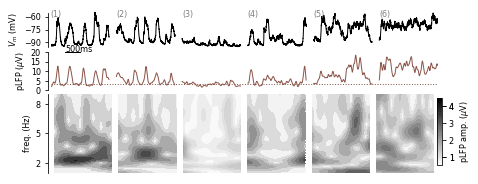

In [383]:
Zooms=[x+np.arange(2)*2 for x in [129.7, 197.8, 115.5, 128, 189.6, 174.6]]
#Zooms=[x+np.arange(2)*2 for x in [198, 115.5, 128, 189.6, 174.6]]
fig_zoom = show_raw_LFP_and_pLFP(data_awake, Zooms, pLFP_lim=[0,20], Tshift=-4, Tspace=.25, Alim=[0,4.2])
fig_zoom.savefig(desktop+'fig.png', dpi=300)

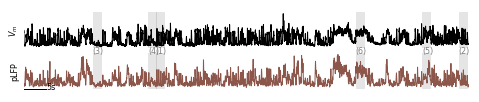

In [384]:
fig_full = show_raw_data_large_scale(data_awake, Zooms=Zooms, Tshift=-5)
#fig_full.savefig(desktop+'fig.png', dpi=300)

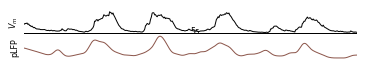

In [340]:
t0, length = 198, 2
fig_full = show_raw_data_large_scale(data_awake, tstart=t0, tend=t0+length, Zooms=[], Tshift=-5)

In [406]:
from graphs.plot_export import put_list_of_figs_to_svg_fig
put_list_of_figs_to_svg_fig([fig_full, fig_zoom],
                            fig_name='paper/Figures/Fig_Various_States.svg',
                            figsize=(0.6,0.23),
                            Props={'XCOORD':[10,0],
                                   'YCOORD':[-5,85],
                                   'XCOORD_LABELS':[-10, -10],
                                   'YCOORD_LABELS':[0, 80],
                                   'LABELS':['a','b']},
                            visualize=True)

## The cortical activation index

In [385]:
def compute_CAI(data, threshold_factor=2., band=[2,10], smoothing=100e-3, window=300e-3):
    print(data['noise_estimate'])
    threshold = threshold_factor*data['noise_estimate']
    freqs_cond = (data['low_freqs']>=band[0]) & (data['low_freqs']<=band[1])
    low_freq_pow = gaussian_smoothing(np.max(np.abs(data['W_low_freqs'])[freqs_cond, :], axis=0), int(smoothing/data['new_dt']))
    mean_pLFP = gaussian_smoothing(\
                          np.abs(data['pLFP']-data['max_of_hist']),
                          int(smoothing/data['new_dt']))
    iwindow = int(window/data['new_dt'])
    print(iwindow)
    CAI = np.zeros(len(data['new_t']))
    for i in range(len(data['new_t'])):
        p_mean = np.mean(low_freq_pow[np.max([i-iwindow, 0]):np.min([i+iwindow, len(data['new_t'])])])
        if p_mean>threshold:
           CAI[i] = -p_mean 
        else:
           CAI[i] = mean_pLFP[i]
    # low_freq_cond = (low_freq_pow>threshold)
    # CAI[low_freq_cond] = -gaussian_smoothing(low_freq_pow, int(smoothing/data['new_dt']))[low_freq_cond]
    # CAI[np.invert(low_freq_cond)] = gaussian_smoothing(\
    #                       np.abs(data['pLFP']-data['max_of_hist']),
    #                       int(smoothing/data['new_dt']))[np.invert(low_freq_cond)]
    data['CAI'] = CAI/data['noise_estimate']

compute_CAI(data_awake)

0.3590884435508372
60


0.3590884435508372
60


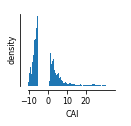

In [386]:
compute_CAI(data_awake, threshold_factor=5.)
fig_hist, ax = figure()
ax.hist(data_awake['CAI'], bins=200, normed=True);
set_plot(ax, ylabel='density', xlabel='CAI', xticks=-10+np.arange(4)*10, yticks=[])
fig_hist.savefig(desktop+'hist.svg')

0.3590884435508372
60


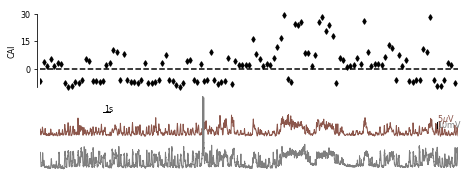

In [387]:
t0, width = 135, 60
spikes=-30
vm_color=Grey
pLFP_color=Brown
Vm_bar = 10
pLFP_bar=5
T_bar=1.
pLFP_loc=-45

def plot_CAI():
    cond = (data_awake['new_t']>t0) & (data_awake['new_t']<t0+width)
    # fig_with_pLFP, AX = figure(axes=(2,1), figsize=(.5,.15), left=.01, bottom=.1)
    fig_with_pLFP, AX = figure(axes=(2,1), figsize=(.8,.2), bottom=.01, left=.3, hspace=0.01)
    ax = AX[1][0]
    ax.plot(data_awake['new_t'][cond],
            data_awake['pLFP'][cond].mean()+data_awake['pLFP'][cond]/pLFP_bar*Vm_bar+pLFP_loc,
            '-', lw=1, color=pLFP_color)
    cond = cond & (data_awake['new_Vm']<spikes)
    ax.plot(data_awake['new_t'][cond], data_awake['new_Vm'][cond], '-', color=vm_color, lw=1)
    cond0 = (data_awake['t']>t0) & (data_awake['t']<t0+width)
    i0 = np.argwhere((data_awake['Vm'][cond0][1:]>spikes) & (data_awake['Vm'][cond0][:-1]<=spikes)).flatten()
    for ii in i0:
        ax.plot(data_awake['t'][cond0][ii-100:ii+100], data_awake['Vm'][cond0][ii-100:ii+100], '-', color=vm_color, lw=1)
    # Tbar
    ax.plot([data_awake['new_t'][cond][0]+T_bar+8, data_awake['new_t'][cond][0]+2*T_bar+8], [10, 10], 'k-', lw=1)
    ax.annotate(str(int(T_bar))+'s', (data_awake['new_t'][cond][0]+T_bar+8+.2, 11), fontsize=FONTSIZE)
    # Vm-LFP bar
    ax.plot([data_awake['new_t'][cond][-1]-3*T_bar, data_awake['new_t'][cond][-1]-3*T_bar],
                          [pLFP_loc/5, pLFP_loc/5-Vm_bar], 'k-', lw=1)
    ax.annotate(str(int(Vm_bar))+'mV', (data_awake['new_t'][cond][-1]-3*T_bar, pLFP_loc/5-Vm_bar), fontsize=FONTSIZE, color=vm_color)
    ax.annotate(str(int(pLFP_bar))+'$\mu$V', (data_awake['new_t'][cond][-1]-3*T_bar, pLFP_loc/5),
                fontsize=FONTSIZE, color=pLFP_color)
    set_plot(ax, [], xlim=[data_awake['new_t'][cond][0], data_awake['new_t'][cond][-1]], yticks=[])
    AX[0][0].plot(data_awake['new_t'][cond][::100], data_awake['CAI'][cond][::100], 'kd', ms=4)
    AX[0][0].plot([data_awake['new_t'][cond][0],data_awake['new_t'][cond][-1]],
                          np.zeros(2), 'k--')
    set_plot(AX[0][0], ['left'], xlim=[data_awake['new_t'][cond][0], data_awake['new_t'][cond][-1]],
                          ylabel='CAI')
    return fig_with_pLFP

compute_CAI(data_awake, threshold_factor=5.8)
fig_with_pLFP = plot_CAI()
#fig_with_pLFP.savefig(desktop+'raw.svg')

# Designing the Real-Time analysis of network states based on the LFP

In [354]:
#######################################################################
## Exporting a sample LFP datafile for the Real-Time troubleshooting ##
#######################################################################
from data_analysis.IO.load_data import load_file
data = load_file('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf')
t, Vm, Extra = data[0], data[1][1], data[1][0]
dt = t[1]-t[0]
new_dt = 5e-4 # 10kHz sampling
idt = int(new_dt/dt)
print(idt)
# cond = (t>120) & (t<200)
cond = (t>160) & (t<170)
Signal = 1e-3*Extra[cond][::idt] # subsampling and in V
#np.savetxt('/Users/yzerlaut/DATA/Awake_LFP_sample.dat', Signal, fmt='%.7e')

10


In [355]:
# let's write a nasty loop version of the wavelet transform

freq = 200. # Hz
w0 = 6.
Tmax = 2**.5 * (w0/(np.pi*freq))
N_length_wvlt = int(2*Tmax/new_dt)
Slow_Time_Scale = 20e-3
ist = int(Slow_Time_Scale/new_dt)

def new_Morlet_Wavelet_TF(real, imag, X, it, f, new_dt, N):
    n = (w0/2./np.sqrt(2.*np.pi)/f)*(1.+np.exp(-w0**2./2.))
    wv = np.exp(-0.5 * (((2.*np.pi*f*(it-N/2)*new_dt)/w0) ** 2))
    real += X*wv*np.cos(2. * np.pi * f * (it-N/2) * new_dt)/n*new_dt
    imag += -X*wv*np.sin(2. * np.pi * f * (it-N/2) * new_dt)/n*new_dt
    return real, imag
    
# LFP_vector = np.zeros(N_length_wvlt)
LFP_vector = np.zeros(1000)
WT = 0*Signal

mean_LFP_last, mean_pLFP = 0, 0
TT, PLFP = [], []
for i in np.arange(len(Signal)):
    wvlt_tf, mean_LFP_new = 0, 0
    real, imag = 0, 0
    for j in np.arange(N_length_wvlt-1,0,-1):
        LFP_vector[j] = LFP_vector[j-1]
        real, imag = new_Morlet_Wavelet_TF(real, imag,
                                           LFP_vector[j]-mean_LFP_last,
                                           j, freq, new_dt, N_length_wvlt)
        mean_LFP_new += LFP_vector[j]/N_length_wvlt
        
    LFP_vector[0] = Signal[i] # and we take the last recorded value
    mean_LFP_last = mean_LFP_new    
    # # we store its norm
    WT[i] = np.sqrt(real**2+imag**2)
    mean_pLFP += WT[i]/ist
    if (i%ist==0):
        PLFP.append(mean_pLFP)
        TT.append(i)
        mean_pLFP = 0

In [347]:
freq = 200. # Hz
w0 = 6.
Tmax = 2**.5 * (w0/(np.pi*freq))
N_length_wvlt = int(2*Tmax/new_dt)
print(N_length_wvlt)

270


In [356]:
coefs = my_cwt(Signal, [freq], new_dt)
amp = np.abs(coefs)

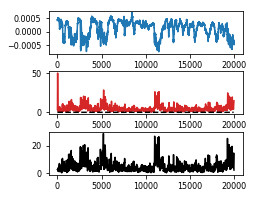

In [357]:
fig, AX = figure(axes=(3,1), figsize=(.5,.3))
AX[0][0].plot(Signal);
AX[1][0].plot(1e6*gaussian_smoothing(WT, 5), color=Red);
AX[1][0].plot(TT, 1e3*np.array(PLFP), 'k--')
AX[2][0].plot(1e6*gaussian_smoothing(amp[0,:], 5), color='k');

In [20]:

def show_Vm_pLFP_spectrogram(data, tstart=-np.inf, tend=np.inf):
    fig, AX = figure(axes_extents=[[[1,1]],[[1,1]],[[1,2]],[[1,2]]],figsize=(0.6,.6), hspace=0.01)
    cond = (data['t']>tstart) & (data['t']<tend)
    plot(data['t'][cond], data['Vm'][cond], ax=AX[0][0], lw=1,
         axes_args={'spines':['left'],'xlim':[data['t'][cond][0],data['t'][cond][-1]], 'ylabel':'$V_m$ (mV)'})
    cond = (data['new_t']>tstart) & (data['new_t']<tend)
    ax=AX[1][0].plot(data['new_t'][cond], data['new_t'][cond]*0+data['max_of_hist'], 'k:', lw=0.5)
    plot(data['new_t'][cond], data['pLFP'][cond], ax=AX[1][0], c=Brown, lw=1,
         axes_args={'spines':['left'],'xlim':[data['new_t'][cond][0],data['new_t'][cond][-1]],
                    'ylabel':'pLFP ('+data['pLFP_unit']+')'})
    c = AX[2][0].contourf(data['new_t'][cond], data['low_freqs'], np.abs(data['W_low_freqs'][:,cond]),
                          cmap=colormap)
    AX[2][0].set_yscale('log')
    set_plot(AX[2][0], ['left'], yticks=[0.1, 0.2, 0.5, 1, 2, 5, 10], ylim=[0.1, 10],
             yticks_labels=['', '0.2', '0.5', '1', '2', '5', ''], ylabel='freq. (Hz)')
    c = AX[3][0].contourf(data['new_t'][cond], data['low_freqs'], np.angle(data['W_low_freqs'][:,cond]), cmap='PRGn')
    AX[3][0].set_yscale('log')
    set_plot(AX[3][0], yticks=[0.1, 0.2, 0.5, 1, 2, 5, 10], ylim=[0.1, 10],
             yticks_labels=['', '0.2', '0.5', '1', '2', '5', ''], ylabel='freq. (Hz)')


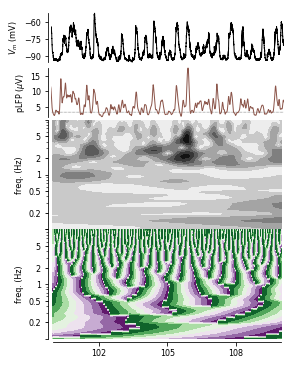

In [22]:
show_Vm_pLFP_spectrogram(data_awake, tstart=50, tend=110)
#show_Vm_pLFP_spectrogram(data_awake)

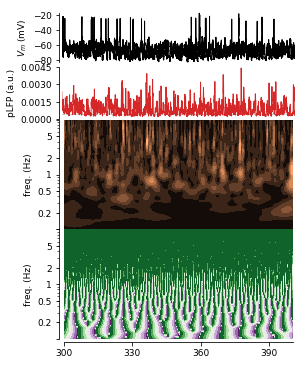

In [459]:
show_Vm_pLFP_spectrogram(data_anesth)

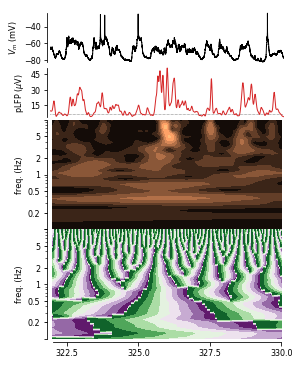

In [39]:
show_Vm_pLFP_spectrogram(data_anesth, tstart=322, tend=330)

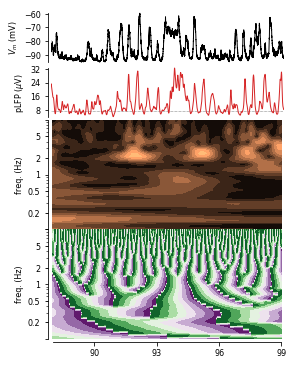

In [40]:
show_Vm_pLFP_spectrogram(data_awake, tstart=88, tend=99)

## Finding the level of ~quiescent activity

Idea: we look for the strongly oscillating samples and we take the
level found in the down phase of those

In [63]:
from graphs.my_graph import *
from scipy.integrate import cumtrapz

def compute_threshold_for_highly_oscill_act(data, threshold=0.95):
    hist, bins = np.histogram(np.abs(data['W_low_freqs']).mean(axis=0), 1000, normed=True)
    return bins[1:][np.argmin((cumtrapz(hist, bins[1:])-threshold)**2)]

def plot_histogram_of_low_freq_power(data, threshold=0.99):
    CUMPROD, BINS = [], []
    for i in range(len(data['low_freqs'])):
        hist, bins = np.histogram(np.abs(data['W_low_freqs'][i,:]), 100, normed=True)
        CUMPROD.append(cumtrapz(hist, bins[1:]))
        BINS.append(bins[2:])
    # plot(X=BINS, Y=CUMPROD, ax=plt.gca(), lw=1, bar_legend_args={}, bar_label='freq')
    plot(X=BINS, Y=CUMPROD, ax=plt.gca(), lw=1)
    hist, bins = np.histogram(np.abs(data['W_low_freqs']).mean(axis=0), 10000, normed=True)
    plot(bins[2:], cumtrapz(hist, bins[1:]), ax=plt.gca(), c='k', lw=3)
    thresh = compute_threshold_for_highly_oscill_act(data, threshold=threshold)
    plt.plot([0, thresh, thresh], [threshold, threshold, 0], 'k--')

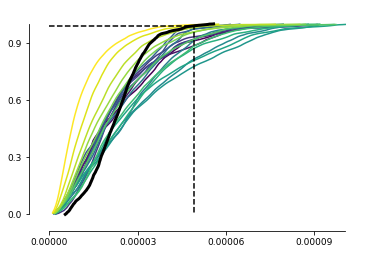

In [64]:
plot_histogram_of_low_freq_power(data_awake)

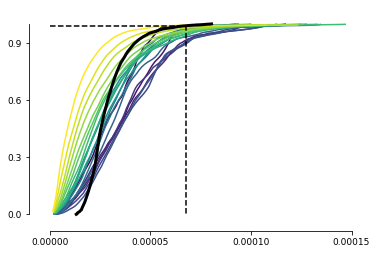

In [65]:
plot_histogram_of_low_freq_power(data_anesth)

In [622]:
def find_times_of_low_phase(data, power_threshold=0.99, phase_extent=np.pi/12):

    pow_thresh = data['max_of_hist'] #compute_threshold_for_highly_oscill_act(data, threshold=power_threshold)
    times, indices = [], []
    for i in range(len(data['new_t'])):
        # find freq of max power
        i0 = np.argmax(np.abs(data['W_low_freqs'][:,i]))
        # if np.abs(np.angle(data['W_low_freqs'][i0,i]))>np.pi/2.:
        cond = (np.abs(np.angle(data['W_low_freqs'][i0,i]))<phase_extent) and\
            (np.abs(data['W_low_freqs'][i0,i])>pow_thresh)
        if cond:
            indices.append(i)
            times.append(data['new_t'][i])
    data['ind_low_phase'] = indices
    data['times_low_phase'] = times

find_times_of_low_phase(data_anesth)
find_times_of_low_phase(data_awake)

In [623]:
def comparison_plot(data):
    figure()
    plt.bar([0], np.mean(data['pLFP']), yerr=np.std(data['pLFP']), color='grey')
    plt.bar([1], np.mean(data['pLFP'][data['ind_low_phase']]),\
            yerr=np.std(data['pLFP'][data['ind_low_phase']]), color=Brown)

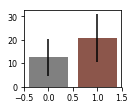

In [624]:
find_times_of_low_phase(data_anesth, phase_extent=np.pi/100., power_threshold=0.99)
comparison_plot(data_anesth)

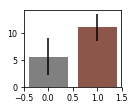

In [625]:
find_times_of_low_phase(data_awake, phase_extent=np.pi/1000., power_threshold=0.9999)
comparison_plot(data_awake)

In [626]:
def see_low_times_of_low_phase_with_Vm(data, zoom=[-np.inf, np.inf]):
    fig, ax = figure(figsize=(1,.3))[1][0][0]
    cond = (data['t']>zoom[0]) & (data['t']<zoom[1])
    plot(data['t'][cond][::10], data['Vm'][cond][::10], lw=1, ax=ax)
    cond = (data['new_t'][data['ind_low_phase']]>zoom[0]) & (data['new_t'][data['ind_low_phase']]<zoom[1])
    scatter(data['new_t'][data['ind_low_phase']][cond],\
            -80.*np.ones(len(np.array(data['ind_low_phase'])[cond])), color=Red, ax=ax)

TypeError: 'AxesSubplot' object does not support indexing

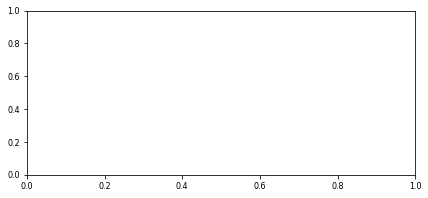

TypeError: 'AxesSubplot' object does not support indexing

In [627]:
see_low_times_of_low_phase_with_Vm(data_anesth, zoom=[320, 340])

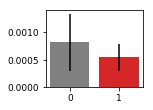

In [458]:
find_times_of_low_phase(data_anesth)
comparison_plot(data_anesth)

In [252]:
power_bins = np.digitize(np.abs(W).mean(axis=0), 100)

(<matplotlib.figure.Figure at 0x1a9a916080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a10b45710>)

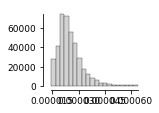

In [247]:
hist(np.abs(W).mean(axis=0))

In [206]:
freqs

array([  0.1       ,   0.1274275 ,   0.16237767,   0.20691381,
         0.26366509,   0.33598183,   0.42813324,   0.54555948,
         0.6951928 ,   0.88586679,   1.12883789,   1.43844989,
         1.83298071,   2.33572147,   2.97635144,   3.79269019,
         4.83293024,   6.15848211,   7.8475997 ,  10.        ])

(<matplotlib.figure.Figure at 0x1a119f3e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a9d280dd8>)

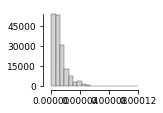

In [204]:
hist(np.abs(W[-1,:]))

(<matplotlib.figure.Figure at 0x1a1047fa90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1042b898>)

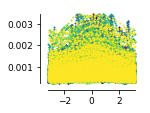

In [200]:
scatter(X=np.angle(W), Y=[data_awake['hGamma_Act'] for i in range(len(W))], ms=1)

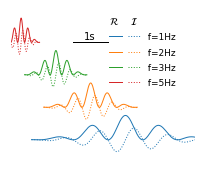

In [303]:
# ewrwkejr
def Custom_Wavelet(t, f, w0=6.):
    x = 2*np.pi*f*t
    output = np.exp(1j * x)
    output = (np.exp(1j * x)+1)/2.*np.exp(-0.5 * ((x/w0) ** 2)) * np.pi ** (-0.25)
    # return (np.real(output)+.5)/2. # note the minus sign to have the 0 phase at bottom
    # return np.real(output)**2 # note the minus sign to have the 0 phase at bottom
    return output # note the minus sign to have the 0 phase at bottom

def Custom_Wavelet_Decay(f, w0=6.):
    return 2 ** .5 * (w0/(np.pi*f))

def from_fourier_to_morlet(freq):
    x = np.linspace(0.1/freq, 2.*freq, 1e3)
    return x[np.argmin((x-freq*(1-np.exp(-freq*x)))**2)]
    
def get_Custom_of_right_size(f, dt, w0=6, with_t=False):
    Tmax = Custom_Wavelet_Decay(f, w0=w0)
    t = np.arange(-int(Tmax/dt), int(Tmax/dt))*dt
    if with_t:
        return t, Custom_Wavelet(t, f, w0=w0)
    else:
        return Custom_Wavelet(t, f, w0=w0)

fig, ax = figure(figsize=(.32,.2), bottom=0.02, left=0.02)     
for i, f in enumerate([1., 2,  3., 5.]):
    t, wvl = get_Custom_of_right_size(f, 0.01, with_t=True)
    plot(t-i, i+np.real(wvl),
         c='C'+str(i), ax=ax, lw=1,
         label='  f='+str(int(f))+'Hz')
    plot(t-i, i+np.imag(wvl), c='C'+str(i), ls=':',
         ax=ax, lw=1,label=' ')
# ax.legend(frameon=False, loc=1)
ax.plot([-1.5,-.5], [3., 3.], 'k-', lw=1)
ax.annotate('1s', (-1.2, 3.1))    
ax.grid('on')
set_plot(plt.gca(), [], ylim=[-1,4], xlim=[-i-.3,2])

LABELS = [ax.lines[i].get_label() for i in range(len(ax.lines))]
leg = plt.legend(ax.lines[0:-1:2]+ax.lines[1::2], LABELS[1:-1:2]+LABELS[::2],
                 loc=(.5,.5), frameon=False,
             title=r'$\mathcal{R}$    $\mathcal{I}$            ',  
             ncol=2, numpoints=3, handletextpad=-0.2, labelspacing=0.7, columnspacing=0.001)
#save_on_desktop(fig, figname='fig.png')

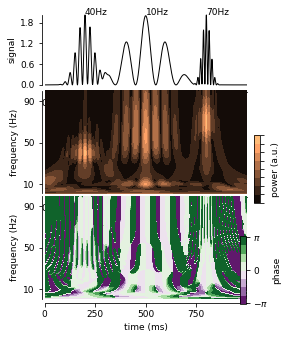

In [315]:
from scipy import signal
def my_custom_transform(data, frequencies, dt):
    
    output = np.zeros([len(frequencies), len(data)], dtype=np.complex)

    for ind, freq in enumerate(frequencies):
        # wavelet_data = np.conj(get_Custom_of_right_size(freq, dt))
        wavelet_data = get_Custom_of_right_size(freq, dt)
        # the wavelets have different integrals
        # conv_number compensates for the number of summed points (i.e. also integral of wavelet)
        conv_number = signal.convolve(np.ones(len(data))+0.*1j, np.ones(len(wavelet_data)),
                                      mode='same')
        # the sliding mean that depends on the frequency
        sliding_mean = signal.convolve(data+0.*1j, np.ones(len(wavelet_data)),
                                       mode='same')/conv_number
        # the final convolution
        output[ind, :] = signal.convolve(data-sliding_mean+0.*1j, wavelet_data,
                                         mode='same')/conv_number
    return output
    
def illustration_plot(t, freqs, data,
                      coefs, phase, dt,
                      tstop, freq1, freq2, freq3,
                      phase_colormap='PRGn',
                      power_colormap=copper):
    """
    a plot to illustrate the output of the wavelet analysis
    """
    fig, AX = figure(figsize=(0.46,0.4),
                     hspace=0.05, wspace=0.01, bottom=0.35, right=.9, left=.43,
                     axes_extents=[[[1,3]],[[1,4]], [[1,4]]])
    # signal plot
    plot(1e3*t, data, c='k', lw=1, ax=AX[0][0],\
         axes_args={'ylabel':'signal', 'xlim':[1e3*t[0], 1e3*t[-1]]})
    for f, tt in zip([freq2, freq1, freq3], [200,500,800]):
        AX[0][0].annotate(str(int(f))+'Hz', (tt, data.max()), fontsize=FONTSIZE)

    # time frequency power plot
    c = AX[1][0].contourf(1e3*t, freqs, coefs, cmap=copper)
    set_plot(AX[1][0], xlim=[1e3*t[0], 1e3*t[-1]],
             ylabel='frequency (Hz)', yticks=[10, 50, 90])
    # inset with legend
    acb = plt.axes([.9, .4, .02, .2])
    cb = plt.colorbar(c, cax=acb, label='power (a.u.)')
    cb.set_ticklabels([])

    # time frequency phase plot
    c = AX[2][0].contourf(1e3*t, freqs, phase, cmap=phase_colormap)
    set_plot(AX[2][0], xlim=[1e3*t[0], 1e3*t[-1]],
             ylabel='frequency (Hz)', yticks=[10, 50, 90],
             xlabel='time (ms)')
    # inset with legend
    acb = plt.axes([.85, .1, .02, .2])
    cb = plt.colorbar(c, cax=acb, label='phase')
    cb.set_ticks([-np.pi, 0, np.pi])
    cb.set_ticklabels(['$-\pi$', '0', '$\pi$'])
    return fig

noise_level = 0.
nfreq = 100

# temporal sampling
dt, tstop = 1e-4, 1.
t = np.arange(int(tstop/dt))*dt

# ### artificially generated signal, transient oscillations
freq1, width1, freq2, width2, freq3, width3 = 10., 100e-3, 40., 40e-3, 70., 20e-3
data  = (1+np.cos(2*np.pi*freq1*t))*np.exp(-(t-.5)**2/2./width1**2)+\
        (1+np.cos(2*np.pi*freq2*t))*np.exp(-(t-.2)**2/2./width2**2)+\
        (1+np.cos(2*np.pi*freq3*t))*np.exp(-(t-.8)**2/2./width3**2)

# ### adding colored noise to test robustness
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/400e-3),\
                    np.random.randn(len(t)), mode='same') # a slow one
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/5e-3),\
                    np.random.randn(len(t)), mode='same') # a faster one

# Continuous Wavelet Transform analysis
freqs = np.linspace(1, 100, nfreq)
coefs = my_custom_transform(data, freqs, dt)

phase = np.angle(coefs)
# cond = np.abs(coefs)<np.max(np.abs(coefs))*0.1
# phase[cond] = np.inf
fig = illustration_plot(t, freqs, data, np.abs(coefs), phase, dt, tstop, freq1, freq2, freq3);
#save_on_desktop(fig, figname='fig.png')

## Commands runned on server to get the results

In [84]:
Script = """# first the wavelet scan
# python exp_data.py -tdw -f data/trial30.npz --discretization 30 --parallelize --subsampling_period 1e-3 
# then the smoothing scan
python exp_data.py -tds -if data/trial30.npz -f data/smooth30.npz --parallelize --discretization 40 --subsampling_period 1e-3 
"""
f = open('cortical_arousal_index/bash_scripts/wavelet_scan.sh', 'w')
f.write(Script)
f.close()

In [83]:
Script = """# the alpha scan
python exp_data.py -tda -f data/alpha40.npz --parallelize --discretization 40 --subsampling_period 1e-3 --alpha_min 1. --alpha_max 7.
"""
f = open('cortical_arousal_index/bash_scripts/alpha_scan.sh', 'w')
f.write(Script)
f.close()

In [72]:
Script = """# the alpha scan
python exp_data.py -gpl -f data/final_depol.npz --parallelize
"""
f = open('cortical_arousal_index/bash_scripts/depol.sh', 'w')
f.write(Script)
f.close()

In [68]:
cat cortical_arousal_index/bash_scripts/wavelet_scan.sh

# first the wavelet scan
python exp_data.py -tdw -f data/trial30.npz --discretization 30 --parallelize --subsampling_period 1e-3 
# then the smoothing scan
python exp_data.py -tds -if data/trial30.npz -f data/smooth30.npz --parallelize --discretization 40 --subsampling_period 1e-3 
